In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# unzip datasets - Classical 3 Composers

## more composers

# Unzip Pop music

In [ ]:
!unzip "/content/drive/MyDrive/Pop-music - One Hot" -d "/content/Pop"

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/Pop/Pop-music - One Hot/Train/091.- 3000.csv  
  inflating: /content/Pop/Pop-music - One Hot/Train/091.- 3200.csv  
  inflating: /content/Pop/Pop-music - One Hot/Train/091.- 3400.csv  
  inflating: /content/Pop/Pop-music - One Hot/Train/091.- 3600.csv  
  inflating: /content/Pop/Pop-music - One Hot/Train/091.- 3800.csv  
  inflating: /content/Pop/Pop-music - One Hot/Train/091.- 400.csv  
  inflating: /content/Pop/Pop-music - One Hot/Train/091.- 4000.csv  
  inflating: /content/Pop/Pop-music - One Hot/Train/091.- 4200.csv  
  inflating: /content/Pop/Pop-music - One Hot/Train/091.- 4400.csv  
  inflating: /content/Pop/Pop-music - One Hot/Train/091.- 4600.csv  
  inflating: /content/Pop/Pop-music - One Hot/Train/091.- 4800.csv  
  inflating: /content/Pop/Pop-music - One Hot/Train/091.- 5000.csv  
  inflating: /content/Pop/Pop-music - One Hot/Train/091.- 5200.csv  
  inflating: /content/Pop/Pop-music - One Hot/Train/091.- 5400.csv  
  inflat

# install

In [ ]:
!pip install torch

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
from torch import optim
import math


# Customized Dataset

In [ ]:

class customDataset2(data.Dataset):
    def __init__(self,folder,subfolders,trainingtype):
        self.folder = folder # this contains subfolders such as mozart
        self.subfolders = subfolders
        self.trainingtype = trainingtype # this is either Train, Val, or Test
        
        subfoldername = self.subfolders # get all the subfoler names such as chopin
        
        # extract desired datasets from each of the subfolders
        all_songs = []
        for foldername in  subfoldername:
            # this gives the path of desired folder: e.g..../Chopin/Train
            dataset_path_in_subfolder = os.path.join(folder,foldername,trainingtype)
            #print("desired folder ",dataset_path_in_subfolder)
            
            # this gives the song names in the desired folder: e.g. k21_op3.mid
            songs_in_dataset = os.listdir(dataset_path_in_subfolder)
            #print("songs: ", songs_in_dataset[:3])
            
            # combine the desired path with the song names: e.g. .../Chopin/Train/k21_op3.mid
            songs = map(lambda fname: os.path.join(dataset_path_in_subfolder,fname),
                                                    songs_in_dataset)
            songs = list(songs)
            #print("songs full: ",songs[:3])
            
            # append the songs to all_songs
            all_songs.extend(songs)
            #print("all songs: ", all_songs[:3])
        
        # hold a list of full file paths
        self.fnames_ful = all_songs
        print("Total samples: ",len(all_songs))
        #print(all_songs[:10])
    
    def __len__(self):
        return len(self.fnames_ful)
    
    def __getitem__(self, index):
        fnames_ful = self.fnames_ful[index]
        roll = pd.read_csv(fnames_ful,header=None)
        roll = np.array(roll)
        # input sequence is from first element til the second last so that
        #  the model could predict from the second element til the last one
        ##input_seq = roll[:-1,:]
        input_seq = roll[:1999,:] # length 500
        # we expect the model to predict the all elements
        ##output_seq = roll[-500:,:]
        ##output_seq = roll[-1000:,:]
        output_seq = roll[1:2000,:] # length 500
        return (input_seq,output_seq)

# Dataloader

In [ ]:
import osqp
folder = "/content/Dataset2"
#subfolders = ["Chopin/Chopin","Beethoven/Beethoven","Liszt/Liszt"]
subfolders = os.listdir(folder)
subfolders

['Clementi',
 'Chopin',
 'Czerny',
 'Mozart',
 'Mendelssohn',
 'Schubert',
 'Beethoven',
 'Haydn',
 'Liszt',
 'Handel_Harpsichord']

In [ ]:
trainingtype = "Train"

train_dataset = customDataset2(folder,subfolders,trainingtype)
train_dataloader = data.DataLoader(train_dataset,batch_size=64,shuffle=True)

# pop - 28375
# classical_3_composer - 24729
 # 63729

Total samples:  63729


In [ ]:
# check
X_train=next(iter(train_dataloader))
print(X_train[0].shape) # input seq
print(X_train[1].shape) # output seq

torch.Size([64, 1999, 88])
torch.Size([64, 1999, 88])


In [ ]:
# validation set: 10138

trainingtype="Val"
#val_dataset = customDataset(path)
val_dataset = customDataset2(folder,subfolders,trainingtype)
# seperate val set into 5 sets because validate 40,000 every time is too much
#  now it would only validate on 8,000
set1 = list(range(0,len(val_dataset),3))
set2 = list(range(1,len(val_dataset),3))
set3 = list(range(2,len(val_dataset),3))
#set4 = list(range(3,len(val_dataset),5))
#set5 = list(range(4,len(val_dataset),5))

val1 = data.Subset(val_dataset,set1)
val2 = data.Subset(val_dataset,set2)
val3 = data.Subset(val_dataset,set3)
#val4 = data.Subset(val_dataset,set4)
#val5 = data.Subset(val_dataset,set5)

size = 64
val_dataloader1 = data.DataLoader(val1,batch_size=size,shuffle=True)
val_dataloader2 = data.DataLoader(val2,batch_size=size,shuffle=True)
val_dataloader3 = data.DataLoader(val3,batch_size=size,shuffle=True)
#val_dataloader4 = data.DataLoader(val4,batch_size=size,shuffle=True)
#val_dataloader5 = data.DataLoader(val5,batch_size=size,shuffle=True)

val_dataloaders = [val_dataloader1,
               val_dataloader2, val_dataloader3]

# pop - 4350 - 2
# classical_3_composer - 3851 - 2
# 10246 - 3

Total samples:  10246


In [ ]:
# check
X_val = next(iter(val_dataloader1))
print(X_val[0].shape) # input seq
print(X_val[1].shape) # output seq

torch.Size([64, 1999, 88])
torch.Size([64, 1999, 88])


## visualization

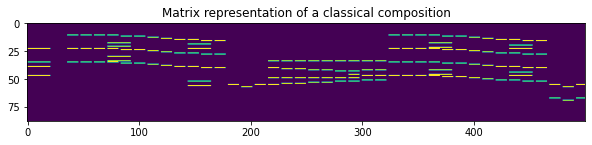

In [ ]:
plt.figure(figsize=(10,7))
plt.title("Matrix representation of a classical composition")
plt.imshow(X_train[0][1][:500].T)

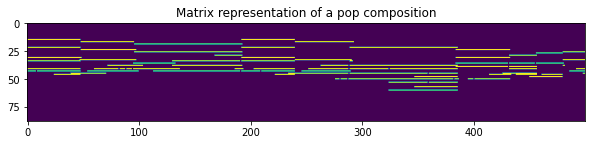

In [ ]:
plt.figure(figsize=(10,7))
plt.title("Matrix representation of a pop composition")
plt.imshow(X_train[0][4][:500].T)

# Training and Validation Routine

In [ ]:
def evaluate(model,val_loader,device,loss_fn):
    model.eval()
    val_loss = 0.0
    steps = 0
    
    for batch in val_loader:
        steps += 1
        input_seq, output_seq = batch
        input_seq, output_seq = input_seq.to(device), output_seq.to(device)
        # try to fix error :"addmm_cuda" not implemented for 'Long'
        input_seq = input_seq.float()
        
        output_seq = output_seq.transpose(0,1).contiguous()
        output_seq = output_seq.contiguous().view(-1)
        
        final,_ = model(input_seq)
        # try to fix:"nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'
        #final, output_seq = final.double(),output_seq.double()
        loss = loss_fn(final,output_seq)
        val_loss += loss.item()
    
    print("The mean validation loss is %.6f" % (val_loss/steps))
    print()
    return val_loss/steps

In [ ]:
def train(model,trainloader,valloaders,ep,print_freq,loss_fun,
          optimizer,device,run,grad_clip=1.0,mname="LSTM"):
    val_loss_best = float("inf")
    
    # total number of training steps
    num_steps = ep * (len(trainloader))
    progress_bar = tqdm(range(num_steps))
    
    # calculate how often print the result
    #  if num_step = 12, and print_freq = 3, then print every 4 steps
    print_every = math.floor(num_steps/print_freq)
    
    # initialize
    steps = 0
    #model.to(device) ## error when run this twice
    model.train()
    train_losses = []
    val_losses = []
    which_val = 0
    
    for e in range(ep):
        current_loss = 0
        for batch in trainloader:
            input_s, output_s = batch
            steps += 1
            input_seq, output_seq = input_s.to(device), output_s.to(device)
            # try to fix error :"addmm_cuda" not implemented for 'Long'
            #  note: output_seq should stay long (int)
            input_seq = input_seq.float()
            #print("input shape: ",input_seq.shape)
            
            output_seq = output_seq.transpose(0,1).contiguous()
            #print("original output shape: ", output_seq.shape)
            output_seq = output_seq.contiguous().view(-1)
            
            #print("output shape: ", output_seq.shape)
            #print("largest output: ", torch.max(output_seq))
            
            # calculate grad and update
            optimizer.zero_grad()
            final,_ = model(input_seq)
            #print("prediction shape: ", final.shape)
            #print("largest prediction: ", torch.max(final.permute(1,0)[0]))
            # calculate loss and record loss
            # try to fix:"nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'
            #final, output_seq = final.double(),output_seq.double()
            #print("final shape: ", final.shape) # (,2)
            #print("output shape: ", output_seq.shape)
            #print("final: ",final[:2,:])
            #print("output_seq:",output_seq[:2])
            loss = loss_fun(final, output_seq)
            #print("loss: ", loss)
            train_losses.append(loss.item())
            current_loss += loss.item()
            #print(current_loss)
            # update parameter
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),grad_clip)
            optimizer.step()
            
            # update progress bar
            progress_bar.update(1)
            
            # print if reach the threshold we want
            if steps % print_every == 0:
                # training loss: divided by the number of steps taken during training
                #  from last print to current print
                print('EPOCHS : {}/{}'.format(e+1,ep),
                          'Loss : {:.6f}'.format(current_loss/print_every))

                current_loss = 0
                #which_val = random.randint(0,4)
                which_val = random.randint(0,1) # now I only have 2 val sets
                # val loss: divided by the number of steps taken when validate
                val_loss = evaluate(model,valloaders[which_val],device,loss_fun)
                val_losses.append(val_loss)
                
                # add call back
                if val_loss < val_loss_best:
                    val_loss_best = val_loss
                    torch.save(model.state_dict(),
                     "/content/drive/MyDrive/Weights/"+mname+"-run-{}-val_loss-BEST.pth".format(run))
                else:
                  torch.save(model.state_dict(),
                     "/content/drive/MyDrive/Weights/"+mname+"-run-{}-val_loss-LAST.pth".format(run))
            model.train()
    return train_losses, val_losses

# Base Model

In [ ]:
class BaseLSTM(nn.Module):
    def __init__(self, input_size = 88, embed_size = 512, hidden_size = 1024, 
                  num_class = 88, layers = 2):
        super(BaseLSTM, self).__init__()
        self.input_size = input_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_class = num_class
        self.layers = layers
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=embed_size)
        self.layernorm_encoder = nn.LayerNorm(embed_size)
        self.layernorm_lstm = nn.LayerNorm(hidden_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,layers)
        self.final = nn.Linear(hidden_size,num_class)
        ###
        #self.final = nn.Linear(hidden_size,128)
        #self.final2 = nn.Linear(128,num_class)
        #self.relu = nn.ReLU()
        ###
        
    def forward(self,sequences,hidden=None):
        # seq shape (batch,seq_len,88)
        notes_encoded = self.notes_encoder(sequences) # shape (batch,seq_len,embed_size)
        #notes_rolled = notes_encoded.permute(1,2,0).contiguous()
                                                      # shape (seq_len,embed_size,batch)
        notes_rolled = notes_encoded
        notes_lnormed = self.layernorm_encoder(notes_rolled)
        notes_lnormed = nn.Dropout(0.3)(notes_lnormed)
        #notes = notes_lnormed.permute(2,0,1)          # shape (batch,seq_len,embed_size)
        notes = notes_lnormed
        
        # output shape (batch,seq_len,hidden_size)
        output, hidden = self.lstm(notes,hidden)
        
        #output_lnormed = self.layernorm_lstm(output.permute(1,2,0).contiguous())
        output_lnormed = self.layernorm_lstm(output)
        output_lnormed = nn.Dropout(0.5)(output_lnormed)
        

        
        # only take the final 1000
        #output_lnormed = output_lnormed[:,-1000:,:] 
        
        # final shape (batch,200,num_class)
        #final = self.final(output_lnormed.permute(2,0,1))
        final = self.final(output_lnormed) # final (batch,200,hidden_size) --> 
                                            #                 (batch,200,88)
        
        ###
        #final = self.relu(final)
        #final = nn.Dropout(0.5)(final)
        #final = self.final2(final)
        
        
        ###
        
        # final shape (200,batch,88)
        final = final.transpose(0,1).contiguous()
        #print("original final shape: ", final.shape)
        
        # create a second measure for prediction per class, shape(seq_len,batch,num_class)
        neg_final = 1 - final
        
        # two "predictions" for each node
        zero_one_final = torch.stack((final,neg_final),dim=3).contiguous()
        
        # flatten everything except for the two predictions dimension
        flatten_final = zero_one_final.view(-1,2)
        
        return flatten_final, hidden

## length 600

### gap 100 - BaseLSTM3com2

In [ ]:
BaseLSTM3com2 = BaseLSTM(input_size = 88, embed_size = 512, hidden_size = 512, 
                  num_class = 88, layers = 2).cuda()

#weights = torch.cuda.FloatTensor([1.0,2.0])
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(BaseLSTM3com2.parameters(),lr=1e-5)
BaseLSTM3com2.load_state_dict(torch.load("/content/drive/MyDrive/Weights/BaseLSTM3com2-run-3-val_loss-BEST.pth"))

<All keys matched successfully>

In [ ]:
train_loss, val_loss = train(BaseLSTM3com2,train_dataloader,val_dataloaders,5,10,
      loss_fun,optimizer,'cuda',4,grad_clip=1.0,mname="BaseLSTM3com2")

  0%|          | 0/780 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.021423
The mean validation loss is 0.020883

EPOCHS : 1/5 Loss : 0.021430
The mean validation loss is 0.020931

EPOCHS : 2/5 Loss : 0.021385
The mean validation loss is 0.020859

EPOCHS : 2/5 Loss : 0.021417
The mean validation loss is 0.020935

EPOCHS : 3/5 Loss : 0.021360
The mean validation loss is 0.020930

EPOCHS : 3/5 Loss : 0.021400
The mean validation loss is 0.020722

EPOCHS : 4/5 Loss : 0.021392
The mean validation loss is 0.021032

EPOCHS : 4/5 Loss : 0.021365
The mean validation loss is 0.020916

EPOCHS : 5/5 Loss : 0.021374
The mean validation loss is 0.021095

EPOCHS : 5/5 Loss : 0.021347
The mean validation loss is 0.021009



In [ ]:
train_loss, val_loss = train(BaseLSTM3com2,train_dataloader,val_dataloaders,5,10,
      loss_fun,optimizer,'cuda',5,grad_clip=1.0,mname="BaseLSTM3com2")

  0%|          | 0/780 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.021228
The mean validation loss is 0.021235

EPOCHS : 1/5 Loss : 0.021465
The mean validation loss is 0.021326

EPOCHS : 2/5 Loss : 0.021348
The mean validation loss is 0.021008

EPOCHS : 2/5 Loss : 0.021330
The mean validation loss is 0.021179

EPOCHS : 3/5 Loss : 0.021336
The mean validation loss is 0.020780

EPOCHS : 3/5 Loss : 0.021315
The mean validation loss is 0.020866

EPOCHS : 4/5 Loss : 0.021316
The mean validation loss is 0.020849

EPOCHS : 4/5 Loss : 0.021336
The mean validation loss is 0.020826

EPOCHS : 5/5 Loss : 0.021259
The mean validation loss is 0.020966

EPOCHS : 5/5 Loss : 0.021391
The mean validation loss is 0.020629



In [ ]:
train_loss, val_loss = train(BaseLSTM3com2,train_dataloader,val_dataloaders,10,20,
      loss_fun,optimizer,'cuda',6,grad_clip=1.0,mname="BaseLSTM3com2")

  0%|          | 0/1560 [00:00<?, ?it/s]

EPOCHS : 1/10 Loss : 0.021354
The mean validation loss is 0.021034

EPOCHS : 1/10 Loss : 0.021286
The mean validation loss is 0.021163

EPOCHS : 2/10 Loss : 0.021320
The mean validation loss is 0.020948

EPOCHS : 2/10 Loss : 0.021277
The mean validation loss is 0.020853

EPOCHS : 3/10 Loss : 0.021242
The mean validation loss is 0.021079

EPOCHS : 3/10 Loss : 0.021322
The mean validation loss is 0.020733

EPOCHS : 4/10 Loss : 0.021238
The mean validation loss is 0.021012

EPOCHS : 4/10 Loss : 0.021316
The mean validation loss is 0.020946

EPOCHS : 5/10 Loss : 0.021245
The mean validation loss is 0.020855

EPOCHS : 5/10 Loss : 0.021309
The mean validation loss is 0.021120

EPOCHS : 6/10 Loss : 0.021275
The mean validation loss is 0.020872

EPOCHS : 6/10 Loss : 0.021245
The mean validation loss is 0.020986

EPOCHS : 7/10 Loss : 0.021195
The mean validation loss is 0.020841

EPOCHS : 7/10 Loss : 0.021342
The mean validation loss is 0.021086

EPOCHS : 8/10 Loss : 0.021290
The mean validatio

## length 2000 - all composers
hiddensize = 2048

In [ ]:
ComplexLSTM1 = BaseLSTM(input_size = 88, embed_size = 512, hidden_size = 2048, 
                  num_class = 88, layers = 2).cuda()
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(ComplexLSTM1.parameters(),lr=1e-7)

In [ ]:
train_loss, val_loss = train(ComplexLSTM1,train_dataloader,val_dataloaders,1,20,
      loss_fun,optimizer,'cuda',1,grad_clip=1.0,mname="ComplexLSTM1")

The mean validation loss is 0.029123

EPOCHS : 1/1 Loss : 0.029443
The mean validation loss is 0.029645

EPOCHS : 1/1 Loss : 0.028373
The mean validation loss is 0.028843

EPOCHS : 1/1 Loss : 0.029211
The mean validation loss is 0.028920

EPOCHS : 1/1 Loss : 0.028194
The mean validation loss is 0.029430

EPOCHS : 1/1 Loss : 0.029017
The mean validation loss is 0.028813



In [ ]:
ComplexLSTM1.load_state_dict(torch.load("/content/drive/MyDrive/Weights/ComplexLSTM1-run-7-val_loss-LAST.pth"))

<All keys matched successfully>

In [ ]:
train_loss, val_loss = train(ComplexLSTM1,train_dataloader,val_dataloaders,5,10,
      loss_fun,optimizer,'cuda',2,grad_clip=1.0,mname="ComplexLSTM1")

  0%|          | 0/1935 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.027755
The mean validation loss is 0.028045

EPOCHS : 1/5 Loss : 0.027895
The mean validation loss is 0.027593

EPOCHS : 2/5 Loss : 0.027705
The mean validation loss is 0.027882

EPOCHS : 2/5 Loss : 0.027754
The mean validation loss is 0.027329

EPOCHS : 3/5 Loss : 0.027453
The mean validation loss is 0.028061

EPOCHS : 3/5 Loss : 0.027829
The mean validation loss is 0.027716

EPOCHS : 4/5 Loss : 0.027225
The mean validation loss is 0.028117

EPOCHS : 4/5 Loss : 0.027866
The mean validation loss is 0.028070



In [ ]:
train_loss, val_loss = train(ComplexLSTM1,train_dataloader,val_dataloaders,20,40,
      loss_fun,optimizer,'cuda',3,grad_clip=1.0,mname="ComplexLSTM1")

  0%|          | 0/7740 [00:00<?, ?it/s]

EPOCHS : 1/20 Loss : 0.027710
The mean validation loss is 0.028141

EPOCHS : 1/20 Loss : 0.027833
The mean validation loss is 0.028587

EPOCHS : 2/20 Loss : 0.027677
The mean validation loss is 0.027716

EPOCHS : 2/20 Loss : 0.027690
The mean validation loss is 0.027535

EPOCHS : 3/20 Loss : 0.027305
The mean validation loss is 0.028228

EPOCHS : 3/20 Loss : 0.027888
The mean validation loss is 0.028064

EPOCHS : 4/20 Loss : 0.027246
The mean validation loss is 0.028376

EPOCHS : 4/20 Loss : 0.027805
The mean validation loss is 0.028217

EPOCHS : 5/20 Loss : 0.027184
The mean validation loss is 0.028104

EPOCHS : 5/20 Loss : 0.027653
The mean validation loss is 0.027780

EPOCHS : 6/20 Loss : 0.026947
The mean validation loss is 0.028287

EPOCHS : 6/20 Loss : 0.027771
The mean validation loss is 0.027994

EPOCHS : 7/20 Loss : 0.026900
The mean validation loss is 0.027822

EPOCHS : 7/20 Loss : 0.027643
The mean validation loss is 0.027690

EPOCHS : 8/20 Loss : 0.026559
The mean validatio

In [ ]:
ComplexLSTM1.load_state_dict(torch.load("/content/drive/MyDrive/Weights/ComplexLSTM1-run-4-val_loss-LAST.pth"))

<All keys matched successfully>

In [ ]:
train_loss, val_loss = train(ComplexLSTM1,train_dataloader,val_dataloaders,10,40,
      loss_fun,optimizer,'cuda',4,grad_clip=1.0,mname="ComplexLSTM1")

  0%|          | 0/3870 [00:00<?, ?it/s]

EPOCHS : 1/10 Loss : 0.027727
The mean validation loss is 0.027612

EPOCHS : 1/10 Loss : 0.027448
The mean validation loss is 0.027695

EPOCHS : 1/10 Loss : 0.027652
The mean validation loss is 0.027548

EPOCHS : 1/10 Loss : 0.027776
The mean validation loss is 0.027461

EPOCHS : 2/10 Loss : 0.026633
The mean validation loss is 0.027842

EPOCHS : 2/10 Loss : 0.027727
The mean validation loss is 0.027714

EPOCHS : 2/10 Loss : 0.027609
The mean validation loss is 0.027723

EPOCHS : 2/10 Loss : 0.027647
The mean validation loss is 0.027528

EPOCHS : 3/10 Loss : 0.025747
The mean validation loss is 0.027695

EPOCHS : 3/10 Loss : 0.027780
The mean validation loss is 0.027707

EPOCHS : 3/10 Loss : 0.027465
The mean validation loss is 0.027900

EPOCHS : 3/10 Loss : 0.027797
The mean validation loss is 0.027681

EPOCHS : 4/10 Loss : 0.025206
The mean validation loss is 0.027936

EPOCHS : 4/10 Loss : 0.027436
The mean validation loss is 0.027647

EPOCHS : 4/10 Loss : 0.027770
The mean validatio

In [ ]:
train_loss, val_loss = train(ComplexLSTM1,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',5,grad_clip=1.0,mname="ComplexLSTM1")

  0%|          | 0/1935 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.027534
The mean validation loss is 0.027344

EPOCHS : 1/5 Loss : 0.027392
The mean validation loss is 0.028174

EPOCHS : 1/5 Loss : 0.027618
The mean validation loss is 0.027736

EPOCHS : 1/5 Loss : 0.027715
The mean validation loss is 0.027427

EPOCHS : 2/5 Loss : 0.026630
The mean validation loss is 0.027530

EPOCHS : 2/5 Loss : 0.027665
The mean validation loss is 0.027484

EPOCHS : 2/5 Loss : 0.027487
The mean validation loss is 0.027868

EPOCHS : 2/5 Loss : 0.027600
The mean validation loss is 0.027783

EPOCHS : 3/5 Loss : 0.025824
The mean validation loss is 0.027655

EPOCHS : 3/5 Loss : 0.027662
The mean validation loss is 0.027732

EPOCHS : 3/5 Loss : 0.027500
The mean validation loss is 0.027664

EPOCHS : 3/5 Loss : 0.027500
The mean validation loss is 0.027735

EPOCHS : 4/5 Loss : 0.025069
The mean validation loss is 0.027679

EPOCHS : 4/5 Loss : 0.027391
The mean validation loss is 0.027586

EPOCHS : 4/5 Loss : 0.027545
The mean validation loss is 0.027

In [ ]:
train_loss, val_loss = train(ComplexLSTM1,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',6,grad_clip=1.0,mname="ComplexLSTM1")

  0%|          | 0/1935 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.027682
The mean validation loss is 0.027637

EPOCHS : 1/5 Loss : 0.027564
The mean validation loss is 0.027664

EPOCHS : 1/5 Loss : 0.027477
The mean validation loss is 0.028056

EPOCHS : 1/5 Loss : 0.027399
The mean validation loss is 0.027699

EPOCHS : 2/5 Loss : 0.026875
The mean validation loss is 0.027595

EPOCHS : 2/5 Loss : 0.027552
The mean validation loss is 0.027333

EPOCHS : 2/5 Loss : 0.027428
The mean validation loss is 0.027698

EPOCHS : 2/5 Loss : 0.027322
The mean validation loss is 0.027829

EPOCHS : 3/5 Loss : 0.025689
The mean validation loss is 0.027537

EPOCHS : 3/5 Loss : 0.027573
The mean validation loss is 0.027375

EPOCHS : 3/5 Loss : 0.027437
The mean validation loss is 0.027644

EPOCHS : 3/5 Loss : 0.027621
The mean validation loss is 0.027481

EPOCHS : 4/5 Loss : 0.025080
The mean validation loss is 0.027578

EPOCHS : 4/5 Loss : 0.027372
The mean validation loss is 0.027896

EPOCHS : 4/5 Loss : 0.027606
The mean validation loss is 0.027

In [ ]:
train_loss, val_loss = train(ComplexLSTM1,train_dataloader,val_dataloaders,20,80,
      loss_fun,optimizer,'cuda',7,grad_clip=1.0,mname="ComplexLSTM1")

  0%|          | 0/7740 [00:00<?, ?it/s]

EPOCHS : 1/20 Loss : 0.027445
The mean validation loss is 0.027939

EPOCHS : 1/20 Loss : 0.027445
The mean validation loss is 0.027634

EPOCHS : 1/20 Loss : 0.027663
The mean validation loss is 0.027837

EPOCHS : 1/20 Loss : 0.027508
The mean validation loss is 0.027656

EPOCHS : 2/20 Loss : 0.026621
The mean validation loss is 0.027765

EPOCHS : 2/20 Loss : 0.027374
The mean validation loss is 0.027459

EPOCHS : 2/20 Loss : 0.027568
The mean validation loss is 0.027496

EPOCHS : 2/20 Loss : 0.027590
The mean validation loss is 0.027349

EPOCHS : 3/20 Loss : 0.025702
The mean validation loss is 0.027259

EPOCHS : 3/20 Loss : 0.027830
The mean validation loss is 0.027436

EPOCHS : 3/20 Loss : 0.027685
The mean validation loss is 0.027943

EPOCHS : 3/20 Loss : 0.027045
The mean validation loss is 0.027784

EPOCHS : 4/20 Loss : 0.024876
The mean validation loss is 0.027807

EPOCHS : 4/20 Loss : 0.027576
The mean validation loss is 0.027851

EPOCHS : 4/20 Loss : 0.027437
The mean validatio

In [ ]:
train_loss, val_loss = train(ComplexLSTM1,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',8,grad_clip=1.0,mname="ComplexLSTM1")

  0%|          | 0/1935 [00:00<?, ?it/s]

RuntimeError: ignored

# ComplexLSTM with more final layers

In [ ]:
class ComplexLSTM(nn.Module):
    def __init__(self, input_size = 88, embed_size = 512, hidden_size = 1024, 
                  num_class = 88, layers = 2):
        super(ComplexLSTM, self).__init__()
        self.input_size = input_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_class = num_class
        self.layers = layers
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=embed_size)
        self.layernorm_encoder = nn.LayerNorm(embed_size)
        self.layernorm_lstm = nn.LayerNorm(hidden_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,layers)
        self.final = nn.Linear(hidden_size,num_class)
        self.final = nn.Linear(hidden_size,512)
        self.final2 = nn.Linear(512,num_class)
        self.relu = nn.ReLU()
        
    def forward(self,sequences,hidden=None):
        # seq shape (batch,seq_len,88)
        notes_encoded = self.notes_encoder(sequences) # shape (batch,seq_len,embed_size)
        #notes_rolled = notes_encoded.permute(1,2,0).contiguous()
                                                      # shape (seq_len,embed_size,batch)
        notes_rolled = notes_encoded
        notes_lnormed = self.layernorm_encoder(notes_rolled)
        notes_lnormed = nn.Dropout(0.3)(notes_lnormed)
        #notes = notes_lnormed.permute(2,0,1)          # shape (batch,seq_len,embed_size)
        notes = notes_lnormed
        
        # output shape (batch,seq_len,hidden_size)
        output, hidden = self.lstm(notes,hidden)
        
        #output_lnormed = self.layernorm_lstm(output.permute(1,2,0).contiguous())
        output_lnormed = self.layernorm_lstm(output)
        output_lnormed = nn.Dropout(0.3)(output_lnormed)
        

        
        # only take the final 1000
        #output_lnormed = output_lnormed[:,-1000:,:] 
        
        # final shape (batch,200,num_class)
        #final = self.final(output_lnormed.permute(2,0,1))
        final = self.final(output_lnormed) # final (batch,200,hidden_size) --> 
                                            #                 (batch,200,88)
        
        final = self.relu(final)
        final = nn.Dropout(0.5)(final)
        final = self.final2(final)
        
        
        
        # final shape (200,batch,88)
        final = final.transpose(0,1).contiguous()
        #print("original final shape: ", final.shape)
        
        # create a second measure for prediction per class, shape(seq_len,batch,num_class)
        neg_final = 1 - final
        
        # two "predictions" for each node
        zero_one_final = torch.stack((final,neg_final),dim=3).contiguous()
        
        # flatten everything except for the two predictions dimension
        flatten_final = zero_one_final.view(-1,2)
        
        return flatten_final, hidden

## more final layers - ComplexLSTM2 - 0.0269~0.027

In [ ]:
ComplexLSTM2 = ComplexLSTM(input_size = 88, embed_size = 512, hidden_size = 2048, 
                  num_class = 88, layers = 2).cuda()
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(ComplexLSTM2.parameters(),lr=1e-4)

In [ ]:
train_loss, val_loss = train(ComplexLSTM2,train_dataloader,val_dataloaders,5,40,
      loss_fun,optimizer,'cuda',1,grad_clip=1.0,mname="ComplexLSTM2")

  0%|          | 0/1935 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.293979
The mean validation loss is 0.167486

EPOCHS : 1/5 Loss : 0.137891
The mean validation loss is 0.092373

EPOCHS : 1/5 Loss : 0.066141
The mean validation loss is 0.051771

EPOCHS : 1/5 Loss : 0.046967
The mean validation loss is 0.043092

EPOCHS : 1/5 Loss : 0.041199
The mean validation loss is 0.039061

EPOCHS : 1/5 Loss : 0.037982
The mean validation loss is 0.037300

EPOCHS : 1/5 Loss : 0.036248
The mean validation loss is 0.035393

EPOCHS : 1/5 Loss : 0.035441
The mean validation loss is 0.034101

EPOCHS : 2/5 Loss : 0.032183
The mean validation loss is 0.033713

EPOCHS : 2/5 Loss : 0.033529
The mean validation loss is 0.033733

EPOCHS : 2/5 Loss : 0.033549
The mean validation loss is 0.032898

EPOCHS : 2/5 Loss : 0.032228
The mean validation loss is 0.032772

EPOCHS : 2/5 Loss : 0.032722
The mean validation loss is 0.032729

EPOCHS : 2/5 Loss : 0.031921
The mean validation loss is 0.031978

EPOCHS : 2/5 Loss : 0.031882
The mean validation loss is 0.031

In [ ]:
train_loss, val_loss = train(ComplexLSTM2,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',2,grad_clip=1.0,mname="ComplexLSTM2")

  0%|          | 0/1935 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.029857
The mean validation loss is 0.029382

EPOCHS : 1/5 Loss : 0.029799
The mean validation loss is 0.029498

EPOCHS : 1/5 Loss : 0.029593
The mean validation loss is 0.029657

EPOCHS : 1/5 Loss : 0.029061
The mean validation loss is 0.029764

EPOCHS : 2/5 Loss : 0.028281
The mean validation loss is 0.029637

EPOCHS : 2/5 Loss : 0.029304
The mean validation loss is 0.029753

EPOCHS : 2/5 Loss : 0.029567
The mean validation loss is 0.029204

EPOCHS : 2/5 Loss : 0.029211
The mean validation loss is 0.029074

EPOCHS : 3/5 Loss : 0.027237
The mean validation loss is 0.029236

EPOCHS : 3/5 Loss : 0.029113
The mean validation loss is 0.028952

EPOCHS : 3/5 Loss : 0.028943
The mean validation loss is 0.029394

EPOCHS : 3/5 Loss : 0.029060
The mean validation loss is 0.028869

EPOCHS : 4/5 Loss : 0.026313
The mean validation loss is 0.028930

EPOCHS : 4/5 Loss : 0.028666
The mean validation loss is 0.029125

EPOCHS : 4/5 Loss : 0.028846
The mean validation loss is 0.028

In [ ]:
train_loss, val_loss = train(ComplexLSTM2,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',3,grad_clip=1.0,mname="ComplexLSTM2")

  0%|          | 0/1935 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.028653
The mean validation loss is 0.028585

EPOCHS : 1/5 Loss : 0.028425
The mean validation loss is 0.028534

EPOCHS : 1/5 Loss : 0.028485
The mean validation loss is 0.028399

EPOCHS : 1/5 Loss : 0.028499
The mean validation loss is 0.028924

EPOCHS : 2/5 Loss : 0.027537
The mean validation loss is 0.028871

EPOCHS : 2/5 Loss : 0.028297
The mean validation loss is 0.028539

EPOCHS : 2/5 Loss : 0.028566
The mean validation loss is 0.028712

EPOCHS : 2/5 Loss : 0.028215
The mean validation loss is 0.027997

EPOCHS : 3/5 Loss : 0.026502
The mean validation loss is 0.028446

EPOCHS : 3/5 Loss : 0.028120
The mean validation loss is 0.028360

EPOCHS : 3/5 Loss : 0.028186
The mean validation loss is 0.028668

EPOCHS : 3/5 Loss : 0.028134
The mean validation loss is 0.028224

EPOCHS : 4/5 Loss : 0.025449
The mean validation loss is 0.028288

EPOCHS : 4/5 Loss : 0.028151
The mean validation loss is 0.028300

EPOCHS : 4/5 Loss : 0.027983
The mean validation loss is 0.028

In [ ]:
train_loss, val_loss = train(ComplexLSTM2,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',4,grad_clip=1.0,mname="ComplexLSTM2")

  0%|          | 0/1935 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.027873
The mean validation loss is 0.027802

EPOCHS : 1/5 Loss : 0.027651
The mean validation loss is 0.028018

EPOCHS : 1/5 Loss : 0.027778
The mean validation loss is 0.028333

EPOCHS : 1/5 Loss : 0.027915
The mean validation loss is 0.027789

EPOCHS : 2/5 Loss : 0.026653
The mean validation loss is 0.027865

EPOCHS : 2/5 Loss : 0.027966
The mean validation loss is 0.027511

EPOCHS : 2/5 Loss : 0.027989
The mean validation loss is 0.027964

EPOCHS : 2/5 Loss : 0.027407
The mean validation loss is 0.027891

EPOCHS : 3/5 Loss : 0.025778
The mean validation loss is 0.027460

EPOCHS : 3/5 Loss : 0.027782
The mean validation loss is 0.027509

EPOCHS : 3/5 Loss : 0.027717
The mean validation loss is 0.027655

EPOCHS : 3/5 Loss : 0.027498
The mean validation loss is 0.027780

EPOCHS : 4/5 Loss : 0.025065
The mean validation loss is 0.027598

EPOCHS : 4/5 Loss : 0.027349
The mean validation loss is 0.027826

EPOCHS : 4/5 Loss : 0.027471
The mean validation loss is 0.027

In [ ]:
train_loss, val_loss = train(ComplexLSTM2,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',5,grad_clip=1.0,mname="ComplexLSTM2")

  0%|          | 0/1935 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.027511
The mean validation loss is 0.027407

EPOCHS : 1/5 Loss : 0.027657
The mean validation loss is 0.027767

EPOCHS : 1/5 Loss : 0.027186
The mean validation loss is 0.027546

EPOCHS : 1/5 Loss : 0.027359
The mean validation loss is 0.027710

EPOCHS : 2/5 Loss : 0.026493
The mean validation loss is 0.027653

EPOCHS : 2/5 Loss : 0.027476
The mean validation loss is 0.027634

EPOCHS : 2/5 Loss : 0.027327
The mean validation loss is 0.027596

EPOCHS : 2/5 Loss : 0.027252
The mean validation loss is 0.027239

EPOCHS : 3/5 Loss : 0.025588
The mean validation loss is 0.027564

EPOCHS : 3/5 Loss : 0.027313
The mean validation loss is 0.027709

EPOCHS : 3/5 Loss : 0.027480
The mean validation loss is 0.027288

EPOCHS : 3/5 Loss : 0.027172
The mean validation loss is 0.027437

EPOCHS : 4/5 Loss : 0.024703
The mean validation loss is 0.027449

EPOCHS : 4/5 Loss : 0.027058
The mean validation loss is 0.027535

EPOCHS : 4/5 Loss : 0.027588
The mean validation loss is 0.027

In [ ]:
train_loss, val_loss = train(ComplexLSTM2,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',6,grad_clip=1.0,mname="ComplexLSTM2")

  0%|          | 0/1935 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.027158
The mean validation loss is 0.027316

EPOCHS : 1/5 Loss : 0.027461
The mean validation loss is 0.027190

EPOCHS : 1/5 Loss : 0.027258
The mean validation loss is 0.027383

EPOCHS : 1/5 Loss : 0.026925
The mean validation loss is 0.027297

EPOCHS : 2/5 Loss : 0.026382
The mean validation loss is 0.027229

EPOCHS : 2/5 Loss : 0.026866
The mean validation loss is 0.027404

EPOCHS : 2/5 Loss : 0.027258
The mean validation loss is 0.027276

EPOCHS : 2/5 Loss : 0.027260
The mean validation loss is 0.027616

EPOCHS : 3/5 Loss : 0.025513
The mean validation loss is 0.027529

EPOCHS : 3/5 Loss : 0.027117
The mean validation loss is 0.027524

EPOCHS : 3/5 Loss : 0.027125
The mean validation loss is 0.027177

EPOCHS : 3/5 Loss : 0.026953
The mean validation loss is 0.027071

EPOCHS : 4/5 Loss : 0.024310
The mean validation loss is 0.026750

EPOCHS : 4/5 Loss : 0.027216
The mean validation loss is 0.027101

EPOCHS : 4/5 Loss : 0.027222
The mean validation loss is 0.027

In [ ]:
train_loss, val_loss = train(ComplexLSTM2,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',7,grad_clip=1.0,mname="ComplexLSTM2")

  0%|          | 0/1935 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.027177
The mean validation loss is 0.027312

EPOCHS : 1/5 Loss : 0.027160
The mean validation loss is 0.027352

EPOCHS : 1/5 Loss : 0.026899
The mean validation loss is 0.027194

EPOCHS : 1/5 Loss : 0.026922
The mean validation loss is 0.027124

EPOCHS : 2/5 Loss : 0.026191
The mean validation loss is 0.027211

EPOCHS : 2/5 Loss : 0.026966
The mean validation loss is 0.026839

EPOCHS : 2/5 Loss : 0.026882
The mean validation loss is 0.026927

EPOCHS : 2/5 Loss : 0.026918
The mean validation loss is 0.026951

EPOCHS : 3/5 Loss : 0.025384
The mean validation loss is 0.026961

EPOCHS : 3/5 Loss : 0.026925
The mean validation loss is 0.027245

EPOCHS : 3/5 Loss : 0.026835
The mean validation loss is 0.027226

EPOCHS : 3/5 Loss : 0.026959
The mean validation loss is 0.026966

EPOCHS : 4/5 Loss : 0.024213
The mean validation loss is 0.027249

EPOCHS : 4/5 Loss : 0.026922
The mean validation loss is 0.027644

EPOCHS : 4/5 Loss : 0.027148
The mean validation loss is 0.026

In [ ]:
train_loss, val_loss = train(ComplexLSTM2,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',8,grad_clip=1.0,mname="ComplexLSTM2")

  0%|          | 0/1935 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.026917
The mean validation loss is 0.027039

EPOCHS : 1/5 Loss : 0.026938
The mean validation loss is 0.026962

EPOCHS : 1/5 Loss : 0.026701
The mean validation loss is 0.027033

EPOCHS : 1/5 Loss : 0.026809
The mean validation loss is 0.027098

EPOCHS : 2/5 Loss : 0.025945
The mean validation loss is 0.027387

EPOCHS : 2/5 Loss : 0.026897
The mean validation loss is 0.026827

EPOCHS : 2/5 Loss : 0.027022
The mean validation loss is 0.027013

EPOCHS : 2/5 Loss : 0.026744
The mean validation loss is 0.026801

EPOCHS : 3/5 Loss : 0.025047
The mean validation loss is 0.027253

EPOCHS : 3/5 Loss : 0.026613
The mean validation loss is 0.026741

EPOCHS : 3/5 Loss : 0.026996
The mean validation loss is 0.027023

EPOCHS : 3/5 Loss : 0.026885
The mean validation loss is 0.027126

EPOCHS : 4/5 Loss : 0.024570
The mean validation loss is 0.027013

EPOCHS : 4/5 Loss : 0.026736
The mean validation loss is 0.027038

EPOCHS : 4/5 Loss : 0.026730
The mean validation loss is 0.026

In [ ]:
train_loss, val_loss = train(ComplexLSTM2,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',9,grad_clip=1.0,mname="ComplexLSTM2")

  0%|          | 0/1935 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.026696
The mean validation loss is 0.027266

EPOCHS : 1/5 Loss : 0.026675
The mean validation loss is 0.027205

EPOCHS : 1/5 Loss : 0.026679
The mean validation loss is 0.026683

EPOCHS : 1/5 Loss : 0.026703
The mean validation loss is 0.027034

EPOCHS : 2/5 Loss : 0.026041
The mean validation loss is 0.027196

EPOCHS : 2/5 Loss : 0.026283
The mean validation loss is 0.027040

EPOCHS : 2/5 Loss : 0.026817
The mean validation loss is 0.027052

EPOCHS : 2/5 Loss : 0.026839
The mean validation loss is 0.026911

EPOCHS : 3/5 Loss : 0.025084
The mean validation loss is 0.026956

EPOCHS : 3/5 Loss : 0.027015
The mean validation loss is 0.026786

EPOCHS : 3/5 Loss : 0.026410
The mean validation loss is 0.026891

EPOCHS : 3/5 Loss : 0.026545
The mean validation loss is 0.027192

EPOCHS : 4/5 Loss : 0.024131
The mean validation loss is 0.026845

EPOCHS : 4/5 Loss : 0.026719
The mean validation loss is 0.026830

EPOCHS : 4/5 Loss : 0.026579
The mean validation loss is 0.026

In [ ]:
train_loss, val_loss = train(ComplexLSTM2,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',10,grad_clip=1.0,mname="ComplexLSTM2")

  0%|          | 0/1935 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.026466
The mean validation loss is 0.026912

EPOCHS : 1/5 Loss : 0.026301
The mean validation loss is 0.026821

EPOCHS : 1/5 Loss : 0.026867
The mean validation loss is 0.026910

EPOCHS : 1/5 Loss : 0.026696
The mean validation loss is 0.026995

EPOCHS : 2/5 Loss : 0.026070
The mean validation loss is 0.027139

EPOCHS : 2/5 Loss : 0.026487
The mean validation loss is 0.026704

EPOCHS : 2/5 Loss : 0.026547
The mean validation loss is 0.026813

EPOCHS : 2/5 Loss : 0.026297
The mean validation loss is 0.027070

EPOCHS : 3/5 Loss : 0.024960
The mean validation loss is 0.026907

EPOCHS : 3/5 Loss : 0.026411
The mean validation loss is 0.026452

EPOCHS : 3/5 Loss : 0.026607
The mean validation loss is 0.026531

EPOCHS : 3/5 Loss : 0.026456
The mean validation loss is 0.026701

EPOCHS : 4/5 Loss : 0.024027
The mean validation loss is 0.027124

EPOCHS : 4/5 Loss : 0.026373
The mean validation loss is 0.027071

EPOCHS : 4/5 Loss : 0.026360
The mean validation loss is 0.026

In [ ]:
train_loss, val_loss = train(ComplexLSTM2,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',11,grad_clip=1.0,mname="ComplexLSTM2")

  0%|          | 0/1935 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.026362
The mean validation loss is 0.026919

EPOCHS : 1/5 Loss : 0.026566
The mean validation loss is 0.027004

EPOCHS : 1/5 Loss : 0.026573
The mean validation loss is 0.027037

EPOCHS : 1/5 Loss : 0.026385
The mean validation loss is 0.026674

EPOCHS : 2/5 Loss : 0.025637
The mean validation loss is 0.026485

EPOCHS : 2/5 Loss : 0.026367
The mean validation loss is 0.026501

EPOCHS : 2/5 Loss : 0.026437
The mean validation loss is 0.026972

EPOCHS : 2/5 Loss : 0.026534
The mean validation loss is 0.026431

EPOCHS : 3/5 Loss : 0.024881
The mean validation loss is 0.026655

EPOCHS : 3/5 Loss : 0.026433
The mean validation loss is 0.026634

EPOCHS : 3/5 Loss : 0.026283
The mean validation loss is 0.026566

EPOCHS : 3/5 Loss : 0.026360
The mean validation loss is 0.026692

EPOCHS : 4/5 Loss : 0.023908
The mean validation loss is 0.026720

EPOCHS : 4/5 Loss : 0.026413
The mean validation loss is 0.026694

EPOCHS : 4/5 Loss : 0.026276
The mean validation loss is 0.026

## fine-tunning ComplexLSTM2 on pop music - PopComplexLSTIM1 - 0.0055

In [ ]:
ComplexLSTM3 = ComplexLSTM(input_size = 88, embed_size = 512, hidden_size = 2048, 
                  num_class = 88, layers = 2).cuda()
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(ComplexLSTM3.parameters(),lr=1e-6)

In [ ]:
ComplexLSTM3.load_state_dict(torch.load("/content/drive/MyDrive/Weights/PopComplexLSTM1-run-1-val_loss-LAST.pth"))

<All keys matched successfully>

In [ ]:
train_loss, val_loss = train(ComplexLSTM3,train_dataloader,val_dataloaders,5,40,
      loss_fun,optimizer,'cuda',1,grad_clip=1.0,mname="PopComplexLSTM1")

  0%|          | 0/2220 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.027416
The mean validation loss is 0.036735

EPOCHS : 1/5 Loss : 0.026103
The mean validation loss is 0.034299

EPOCHS : 1/5 Loss : 0.025762
The mean validation loss is 0.033137

EPOCHS : 1/5 Loss : 0.025293
The mean validation loss is 0.032061

EPOCHS : 1/5 Loss : 0.024934
The mean validation loss is 0.032465

EPOCHS : 1/5 Loss : 0.024584
The mean validation loss is 0.031586

EPOCHS : 1/5 Loss : 0.024457
The mean validation loss is 0.031993



KeyboardInterrupt: ignored

It is not learning much, try to lower the lr

In [ ]:

train_loss, val_loss = train(ComplexLSTM3,train_dataloader,val_dataloaders,5,40,
      loss_fun,optimizer,'cuda',1,grad_clip=1.0,mname="PopComplexLSTM1")

  0%|          | 0/2220 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.024280
The mean validation loss is 0.031801

EPOCHS : 1/5 Loss : 0.024361
The mean validation loss is 0.031723

EPOCHS : 1/5 Loss : 0.024345
The mean validation loss is 0.031751

EPOCHS : 1/5 Loss : 0.024123
The mean validation loss is 0.031831



KeyboardInterrupt: ignored

## training pop model from scratch - PopComplexLSTM2

In [ ]:
PopComplexLSTM2 = ComplexLSTM(input_size = 88, embed_size = 512, hidden_size = 2048, 
                  num_class = 88, layers = 2).cuda()
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(PopComplexLSTM2.parameters(),lr=1e-5)

In [ ]:
train_loss, val_loss = train(PopComplexLSTM2,train_dataloader,val_dataloaders,5,40,
      loss_fun,optimizer,'cuda',1,grad_clip=1.0,mname="PopComplexLSTM2")

  0%|          | 0/2220 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.343741
The mean validation loss is 0.037355

EPOCHS : 1/5 Loss : 0.101685
The mean validation loss is 0.002692

EPOCHS : 1/5 Loss : 0.047881
The mean validation loss is 0.001569

EPOCHS : 1/5 Loss : 0.037989
The mean validation loss is 0.004210

EPOCHS : 1/5 Loss : 0.034555
The mean validation loss is 0.007076

EPOCHS : 1/5 Loss : 0.031910
The mean validation loss is 0.008761

EPOCHS : 1/5 Loss : 0.030584
The mean validation loss is 0.007479

EPOCHS : 1/5 Loss : 0.029811
The mean validation loss is 0.008380

EPOCHS : 2/5 Loss : 0.027049
The mean validation loss is 0.008197

EPOCHS : 2/5 Loss : 0.028682
The mean validation loss is 0.007908

EPOCHS : 2/5 Loss : 0.028070
The mean validation loss is 0.006464

EPOCHS : 2/5 Loss : 0.027688
The mean validation loss is 0.005543

EPOCHS : 2/5 Loss : 0.027264
The mean validation loss is 0.006145

EPOCHS : 2/5 Loss : 0.027271
The mean validation loss is 0.005657

EPOCHS : 2/5 Loss : 0.026933
The mean validation loss is 0.005

In [ ]:
train_loss, val_loss = train(PopComplexLSTM2,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',2,grad_clip=1.0,mname="PopComplexLSTM2")

  0%|          | 0/2220 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.024242
The mean validation loss is 0.005171

EPOCHS : 1/5 Loss : 0.024076
The mean validation loss is 0.004336

EPOCHS : 1/5 Loss : 0.023996
The mean validation loss is 0.005768

EPOCHS : 1/5 Loss : 0.023880
The mean validation loss is 0.006156

EPOCHS : 2/5 Loss : 0.023744
The mean validation loss is 0.006060

EPOCHS : 2/5 Loss : 0.023668
The mean validation loss is 0.005376

EPOCHS : 2/5 Loss : 0.023467
The mean validation loss is 0.005867

EPOCHS : 2/5 Loss : 0.023407
The mean validation loss is 0.005542

EPOCHS : 3/5 Loss : 0.023312
The mean validation loss is 0.005062

EPOCHS : 3/5 Loss : 0.023071
The mean validation loss is 0.005624

EPOCHS : 3/5 Loss : 0.022997
The mean validation loss is 0.005157

EPOCHS : 3/5 Loss : 0.023193
The mean validation loss is 0.005163

EPOCHS : 4/5 Loss : 0.023097
The mean validation loss is 0.005115

EPOCHS : 4/5 Loss : 0.022924
The mean validation loss is 0.006117

EPOCHS : 4/5 Loss : 0.022622
The mean validation loss is 0.006

In [ ]:
train_loss, val_loss = train(PopComplexLSTM2,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',3,grad_clip=1.0,mname="PopComplexLSTM2")

  0%|          | 0/2220 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.022407
The mean validation loss is 0.005214

EPOCHS : 1/5 Loss : 0.022222
The mean validation loss is 0.006503

EPOCHS : 1/5 Loss : 0.022424
The mean validation loss is 0.006552

EPOCHS : 1/5 Loss : 0.022305
The mean validation loss is 0.005984

EPOCHS : 2/5 Loss : 0.022216
The mean validation loss is 0.006147

EPOCHS : 2/5 Loss : 0.022034
The mean validation loss is 0.006739

EPOCHS : 2/5 Loss : 0.022146
The mean validation loss is 0.006307

EPOCHS : 2/5 Loss : 0.022235
The mean validation loss is 0.004976

EPOCHS : 3/5 Loss : 0.022057
The mean validation loss is 0.005892

EPOCHS : 3/5 Loss : 0.022018
The mean validation loss is 0.004759

EPOCHS : 3/5 Loss : 0.021994
The mean validation loss is 0.004785

EPOCHS : 3/5 Loss : 0.021887
The mean validation loss is 0.005845

EPOCHS : 4/5 Loss : 0.021807
The mean validation loss is 0.005046

EPOCHS : 4/5 Loss : 0.021855
The mean validation loss is 0.005563

EPOCHS : 4/5 Loss : 0.021778
The mean validation loss is 0.006

In [ ]:
optimizer = optim.AdamW(PopComplexLSTM2.parameters(),lr=1e-7)
train_loss, val_loss = train(PopComplexLSTM2,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',4,grad_clip=1.0,mname="PopComplexLSTM2")

  0%|          | 0/2220 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.021566
The mean validation loss is 0.005136

EPOCHS : 1/5 Loss : 0.021477
The mean validation loss is 0.005177

EPOCHS : 1/5 Loss : 0.021550
The mean validation loss is 0.005211

EPOCHS : 1/5 Loss : 0.021661
The mean validation loss is 0.005283

EPOCHS : 2/5 Loss : 0.021594
The mean validation loss is 0.005311

EPOCHS : 2/5 Loss : 0.021644
The mean validation loss is 0.005326

EPOCHS : 2/5 Loss : 0.021439
The mean validation loss is 0.005319

EPOCHS : 2/5 Loss : 0.021497
The mean validation loss is 0.005342

EPOCHS : 3/5 Loss : 0.021534
The mean validation loss is 0.005366

EPOCHS : 3/5 Loss : 0.021468
The mean validation loss is 0.005367

EPOCHS : 3/5 Loss : 0.021524
The mean validation loss is 0.005408

EPOCHS : 3/5 Loss : 0.021613
The mean validation loss is 0.005395

EPOCHS : 4/5 Loss : 0.021362
The mean validation loss is 0.005368

EPOCHS : 4/5 Loss : 0.021598
The mean validation loss is 0.005401

EPOCHS : 4/5 Loss : 0.021468
The mean validation loss is 0.005

In [ ]:

train_loss, val_loss = train(PopComplexLSTM2,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',5,grad_clip=1.0,mname="PopComplexLSTM2")

  0%|          | 0/2220 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.021634
The mean validation loss is 0.005457

EPOCHS : 1/5 Loss : 0.021454
The mean validation loss is 0.005470

EPOCHS : 1/5 Loss : 0.021528
The mean validation loss is 0.005457

EPOCHS : 1/5 Loss : 0.021462
The mean validation loss is 0.005421

EPOCHS : 2/5 Loss : 0.021516
The mean validation loss is 0.005447

EPOCHS : 2/5 Loss : 0.021450
The mean validation loss is 0.005423

EPOCHS : 2/5 Loss : 0.021565
The mean validation loss is 0.005453

EPOCHS : 2/5 Loss : 0.021541
The mean validation loss is 0.005481

EPOCHS : 3/5 Loss : 0.021595
The mean validation loss is 0.005517

EPOCHS : 3/5 Loss : 0.021505
The mean validation loss is 0.005496

EPOCHS : 3/5 Loss : 0.021412
The mean validation loss is 0.005489

EPOCHS : 3/5 Loss : 0.021532
The mean validation loss is 0.005463

EPOCHS : 4/5 Loss : 0.021647
The mean validation loss is 0.005475

EPOCHS : 4/5 Loss : 0.021581
The mean validation loss is 0.005483

EPOCHS : 4/5 Loss : 0.021524
The mean validation loss is 0.005

In [ ]:
train_loss, val_loss = train(PopComplexLSTM2,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',6,grad_clip=1.0,mname="PopComplexLSTM2")

  0%|          | 0/2220 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.021442
The mean validation loss is 0.005498

EPOCHS : 1/5 Loss : 0.021508
The mean validation loss is 0.005494

EPOCHS : 1/5 Loss : 0.021565
The mean validation loss is 0.005488

EPOCHS : 1/5 Loss : 0.021517
The mean validation loss is 0.005507

EPOCHS : 2/5 Loss : 0.021582
The mean validation loss is 0.005509

EPOCHS : 2/5 Loss : 0.021574
The mean validation loss is 0.005516

EPOCHS : 2/5 Loss : 0.021432
The mean validation loss is 0.005517

EPOCHS : 2/5 Loss : 0.021445
The mean validation loss is 0.005498

EPOCHS : 3/5 Loss : 0.021564
The mean validation loss is 0.005564

EPOCHS : 3/5 Loss : 0.021506
The mean validation loss is 0.005506

EPOCHS : 3/5 Loss : 0.021403
The mean validation loss is 0.005499

EPOCHS : 3/5 Loss : 0.021530
The mean validation loss is 0.005513

EPOCHS : 4/5 Loss : 0.021558
The mean validation loss is 0.005528

EPOCHS : 4/5 Loss : 0.021479
The mean validation loss is 0.005524

EPOCHS : 4/5 Loss : 0.021560
The mean validation loss is 0.005

# SimpleLSTM

In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size = 88, embed_size = 128, hidden_size = 512, 
                  num_class = 88, layers = 1):
        super(SimpleLSTM, self).__init__()
        self.input_size = input_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_class = num_class
        self.layers = layers
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=embed_size)
        self.layernorm_encoder = nn.LayerNorm(embed_size)
        self.layernorm_lstm = nn.LayerNorm(hidden_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,layers)
        self.final = nn.Linear(hidden_size,num_class)
        
    def forward(self,sequences,hidden=None):
        # seq shape (batch,seq_len,88)
        notes_encoded = self.notes_encoder(sequences) # shape (batch,seq_len,embed_size)
        #notes_rolled = notes_encoded.permute(1,2,0).contiguous()
                                                      # shape (seq_len,embed_size,batch)
        notes_rolled = notes_encoded
        notes_lnormed = self.layernorm_encoder(notes_rolled)
        notes_lnormed = nn.Dropout(0.1)(notes_lnormed)
        #notes = notes_lnormed.permute(2,0,1)          # shape (batch,seq_len,embed_size)
        notes = notes_lnormed
        
        # output shape (batch,seq_len,hidden_size)
        output, hidden = self.lstm(notes,hidden)
        
        #output_lnormed = self.layernorm_lstm(output.permute(1,2,0).contiguous())
        output_lnormed = self.layernorm_lstm(output)
        output_lnormed = nn.Dropout(0.1)(output_lnormed)
        

        
        # only take the final 1000
        #output_lnormed = output_lnormed[:,-1000:,:] 
        
        # final shape (batch,200,num_class)
        #final = self.final(output_lnormed.permute(2,0,1))
        final = self.final(output_lnormed) # final (batch,200,hidden_size) --> 
                 #        (batch,200,88)
        
        
        
        # final shape (200,batch,88)
        final = final.transpose(0,1).contiguous()
        #print("original final shape: ", final.shape)
        
        # create a second measure for prediction per class, shape(seq_len,batch,num_class)
        neg_final = 1 - final
        
        # two "predictions" for each node
        zero_one_final = torch.stack((final,neg_final),dim=3).contiguous()
        
        # flatten everything except for the two predictions dimension
        flatten_final = zero_one_final.view(-1,2)
        
        return flatten_final, hidden

## PopSimpleLSTM1 - 0.0046

In [ ]:
PopSimpleLSTM = SimpleLSTM(input_size = 88, embed_size = 256, hidden_size = 512, 
                  num_class = 88, layers = 1).cuda()
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(PopSimpleLSTM.parameters(),lr=1e-7)

In [ ]:
train_loss, val_loss = train(PopSimpleLSTM,train_dataloader,val_dataloaders,5,40,
      loss_fun,optimizer,'cuda',1,grad_clip=1.0,mname="PopSimpleLSTM")

  0%|          | 0/2220 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.355269
The mean validation loss is 0.056985

EPOCHS : 1/5 Loss : 0.128324
The mean validation loss is 0.025282

EPOCHS : 1/5 Loss : 0.076909
The mean validation loss is 0.011443

EPOCHS : 1/5 Loss : 0.053107
The mean validation loss is 0.006180

EPOCHS : 1/5 Loss : 0.041544
The mean validation loss is 0.003902

EPOCHS : 1/5 Loss : 0.035190
The mean validation loss is 0.002709

EPOCHS : 1/5 Loss : 0.031404
The mean validation loss is 0.001986

EPOCHS : 1/5 Loss : 0.028980
The mean validation loss is 0.001613

EPOCHS : 2/5 Loss : 0.025218
The mean validation loss is 0.001358

EPOCHS : 2/5 Loss : 0.025937
The mean validation loss is 0.001188

EPOCHS : 2/5 Loss : 0.025238
The mean validation loss is 0.001105

EPOCHS : 2/5 Loss : 0.024493
The mean validation loss is 0.001052

EPOCHS : 2/5 Loss : 0.024071
The mean validation loss is 0.001028

EPOCHS : 2/5 Loss : 0.023817
The mean validation loss is 0.001035

EPOCHS : 2/5 Loss : 0.023458
The mean validation loss is 0.001

In [ ]:
train_loss, val_loss = train(PopSimpleLSTM,train_dataloader,val_dataloaders,10,20,
      loss_fun,optimizer,'cuda',2,grad_clip=1.0,mname="PopSimpleLSTM")

  0%|          | 0/4440 [00:00<?, ?it/s]

EPOCHS : 1/10 Loss : 0.020980
The mean validation loss is 0.006506

EPOCHS : 1/10 Loss : 0.020810
The mean validation loss is 0.006562

EPOCHS : 2/10 Loss : 0.020679
The mean validation loss is 0.006412

EPOCHS : 2/10 Loss : 0.020686
The mean validation loss is 0.006440

EPOCHS : 3/10 Loss : 0.020504
The mean validation loss is 0.006667

EPOCHS : 3/10 Loss : 0.020521
The mean validation loss is 0.006178

EPOCHS : 4/10 Loss : 0.020433
The mean validation loss is 0.005828

EPOCHS : 4/10 Loss : 0.020297
The mean validation loss is 0.005748

EPOCHS : 5/10 Loss : 0.020291
The mean validation loss is 0.005748

EPOCHS : 5/10 Loss : 0.020183
The mean validation loss is 0.005413

EPOCHS : 6/10 Loss : 0.020134
The mean validation loss is 0.005800

EPOCHS : 6/10 Loss : 0.020122
The mean validation loss is 0.005728

EPOCHS : 7/10 Loss : 0.020073
The mean validation loss is 0.006002

EPOCHS : 7/10 Loss : 0.020001
The mean validation loss is 0.005690

EPOCHS : 8/10 Loss : 0.019991
The mean validatio

In [ ]:
train_loss, val_loss = train(PopSimpleLSTM,train_dataloader,val_dataloaders,10,20,
      loss_fun,optimizer,'cuda',3,grad_clip=1.0,mname="PopSimpleLSTM")

  0%|          | 0/4440 [00:00<?, ?it/s]

EPOCHS : 1/10 Loss : 0.019776
The mean validation loss is 0.006039

EPOCHS : 1/10 Loss : 0.019700
The mean validation loss is 0.005799

EPOCHS : 2/10 Loss : 0.019696
The mean validation loss is 0.005211

EPOCHS : 2/10 Loss : 0.019658
The mean validation loss is 0.005682

EPOCHS : 3/10 Loss : 0.019657
The mean validation loss is 0.005324

EPOCHS : 3/10 Loss : 0.019604
The mean validation loss is 0.005563

EPOCHS : 4/10 Loss : 0.019624
The mean validation loss is 0.005309

EPOCHS : 4/10 Loss : 0.019547
The mean validation loss is 0.005432

EPOCHS : 5/10 Loss : 0.019576
The mean validation loss is 0.005375

EPOCHS : 5/10 Loss : 0.019508
The mean validation loss is 0.005564

EPOCHS : 6/10 Loss : 0.019533
The mean validation loss is 0.005547

EPOCHS : 6/10 Loss : 0.019477
The mean validation loss is 0.005455

EPOCHS : 7/10 Loss : 0.019455
The mean validation loss is 0.005468

EPOCHS : 7/10 Loss : 0.019480
The mean validation loss is 0.005124

EPOCHS : 8/10 Loss : 0.019427
The mean validatio

In [ ]:
train_loss, val_loss = train(PopSimpleLSTM,train_dataloader,val_dataloaders,10,20,
      loss_fun,optimizer,'cuda',4,grad_clip=1.0,mname="PopSimpleLSTM")

  0%|          | 0/4440 [00:00<?, ?it/s]

EPOCHS : 1/10 Loss : 0.019320
The mean validation loss is 0.005207

EPOCHS : 1/10 Loss : 0.019390
The mean validation loss is 0.004960

EPOCHS : 2/10 Loss : 0.019367
The mean validation loss is 0.004984

EPOCHS : 2/10 Loss : 0.019289
The mean validation loss is 0.005289

EPOCHS : 3/10 Loss : 0.019316
The mean validation loss is 0.004891

EPOCHS : 3/10 Loss : 0.019290
The mean validation loss is 0.004941

EPOCHS : 4/10 Loss : 0.019328
The mean validation loss is 0.005478

EPOCHS : 4/10 Loss : 0.019238
The mean validation loss is 0.004745

EPOCHS : 5/10 Loss : 0.019282
The mean validation loss is 0.005374

EPOCHS : 5/10 Loss : 0.019238
The mean validation loss is 0.004574

EPOCHS : 6/10 Loss : 0.019199
The mean validation loss is 0.005018

EPOCHS : 6/10 Loss : 0.019295
The mean validation loss is 0.004953

EPOCHS : 7/10 Loss : 0.019213
The mean validation loss is 0.004911

EPOCHS : 7/10 Loss : 0.019241
The mean validation loss is 0.004693

EPOCHS : 8/10 Loss : 0.019214
The mean validatio

In [ ]:
train_loss, val_loss = train(PopSimpleLSTM,train_dataloader,val_dataloaders,10,20,
      loss_fun,optimizer,'cuda',5,grad_clip=1.0,mname="PopSimpleLSTM")

  0%|          | 0/4440 [00:00<?, ?it/s]

EPOCHS : 1/10 Loss : 0.019150
The mean validation loss is 0.005104

EPOCHS : 1/10 Loss : 0.019182
The mean validation loss is 0.005142

EPOCHS : 2/10 Loss : 0.019155
The mean validation loss is 0.004727

EPOCHS : 2/10 Loss : 0.019154
The mean validation loss is 0.004916

EPOCHS : 3/10 Loss : 0.019168
The mean validation loss is 0.004725

EPOCHS : 3/10 Loss : 0.019116
The mean validation loss is 0.004973

EPOCHS : 4/10 Loss : 0.019117
The mean validation loss is 0.004814

EPOCHS : 4/10 Loss : 0.019147
The mean validation loss is 0.004690

EPOCHS : 5/10 Loss : 0.019086
The mean validation loss is 0.005335

EPOCHS : 5/10 Loss : 0.019148
The mean validation loss is 0.004567

EPOCHS : 6/10 Loss : 0.019198
The mean validation loss is 0.004836

EPOCHS : 6/10 Loss : 0.019015
The mean validation loss is 0.004306

EPOCHS : 7/10 Loss : 0.019062
The mean validation loss is 0.004876

EPOCHS : 7/10 Loss : 0.019132
The mean validation loss is 0.005603

EPOCHS : 8/10 Loss : 0.019034
The mean validatio

In [ ]:
PopSimpleLSTM.load_state_dict(torch.load("/content/drive/MyDrive/Weights/PopSimpleLSTM-run-5-val_loss-BEST.pth"))
train_loss, val_loss = train(PopSimpleLSTM,train_dataloader,val_dataloaders,10,20,
      loss_fun,optimizer,'cuda',6,grad_clip=1.0,mname="PopSimpleLSTM")

  0%|          | 0/4440 [00:00<?, ?it/s]

EPOCHS : 1/10 Loss : 0.019079
The mean validation loss is 0.004336

EPOCHS : 1/10 Loss : 0.019098
The mean validation loss is 0.004372

EPOCHS : 2/10 Loss : 0.019052
The mean validation loss is 0.004420

EPOCHS : 2/10 Loss : 0.019117
The mean validation loss is 0.004453

EPOCHS : 3/10 Loss : 0.019089
The mean validation loss is 0.004471

EPOCHS : 3/10 Loss : 0.019093
The mean validation loss is 0.004512

EPOCHS : 4/10 Loss : 0.019105
The mean validation loss is 0.004523

EPOCHS : 4/10 Loss : 0.019071
The mean validation loss is 0.004545

EPOCHS : 5/10 Loss : 0.019055
The mean validation loss is 0.004568

EPOCHS : 5/10 Loss : 0.019101
The mean validation loss is 0.004600

EPOCHS : 6/10 Loss : 0.019127
The mean validation loss is 0.004606

EPOCHS : 6/10 Loss : 0.019033
The mean validation loss is 0.004622

EPOCHS : 7/10 Loss : 0.019049
The mean validation loss is 0.004650



In [ ]:
train_loss, val_loss = train(PopSimpleLSTM,train_dataloader,val_dataloaders,10,20,
      loss_fun,optimizer,'cuda',7,grad_clip=1.0,mname="PopSimpleLSTM")

## ClassicalSimpleLSTM - 0.0265

In [ ]:
ClassicalSimpleLSTM = SimpleLSTM(input_size = 88, embed_size = 256, hidden_size = 512, 
                  num_class = 88, layers = 1).cuda()
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(ClassicalSimpleLSTM.parameters(),lr=1e-4)

In [ ]:
train_loss, val_loss = train(ClassicalSimpleLSTM,train_dataloader,val_dataloaders,5,40,
      loss_fun,optimizer,'cuda',1,grad_clip=1.0,mname="ClassicalSimpleLSTM")

  0%|          | 0/1935 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.348097
The mean validation loss is 0.117807

EPOCHS : 1/5 Loss : 0.103006
The mean validation loss is 0.085840

EPOCHS : 1/5 Loss : 0.072870
The mean validation loss is 0.061899

EPOCHS : 1/5 Loss : 0.054865
The mean validation loss is 0.049152

EPOCHS : 1/5 Loss : 0.046151
The mean validation loss is 0.042960

EPOCHS : 1/5 Loss : 0.041025
The mean validation loss is 0.039076

EPOCHS : 1/5 Loss : 0.038595
The mean validation loss is 0.037094

EPOCHS : 1/5 Loss : 0.036230
The mean validation loss is 0.035111

EPOCHS : 2/5 Loss : 0.032675
The mean validation loss is 0.034110

EPOCHS : 2/5 Loss : 0.033466
The mean validation loss is 0.033720

EPOCHS : 2/5 Loss : 0.032754
The mean validation loss is 0.032172

EPOCHS : 2/5 Loss : 0.032138
The mean validation loss is 0.031701

EPOCHS : 2/5 Loss : 0.031283
The mean validation loss is 0.031210

EPOCHS : 2/5 Loss : 0.031305
The mean validation loss is 0.031403

EPOCHS : 2/5 Loss : 0.030521
The mean validation loss is 0.030

In [ ]:
train_loss, val_loss = train(ClassicalSimpleLSTM,train_dataloader,val_dataloaders,10,20,
      loss_fun,optimizer,'cuda',2,grad_clip=1.0,mname="ClassicalSimpleLSTM")

  0%|          | 0/3870 [00:00<?, ?it/s]

EPOCHS : 1/10 Loss : 0.027773
The mean validation loss is 0.027825

EPOCHS : 1/10 Loss : 0.027622
The mean validation loss is 0.027958

EPOCHS : 2/10 Loss : 0.027319
The mean validation loss is 0.027650

EPOCHS : 2/10 Loss : 0.027556
The mean validation loss is 0.027456

EPOCHS : 3/10 Loss : 0.027244
The mean validation loss is 0.027225

EPOCHS : 3/10 Loss : 0.027215
The mean validation loss is 0.027615

EPOCHS : 4/10 Loss : 0.026891
The mean validation loss is 0.027182

EPOCHS : 4/10 Loss : 0.027175
The mean validation loss is 0.027148

EPOCHS : 5/10 Loss : 0.026574
The mean validation loss is 0.027207

EPOCHS : 5/10 Loss : 0.027154
The mean validation loss is 0.027164

EPOCHS : 6/10 Loss : 0.026428
The mean validation loss is 0.027148

EPOCHS : 6/10 Loss : 0.027015
The mean validation loss is 0.027026

EPOCHS : 7/10 Loss : 0.026096
The mean validation loss is 0.027105

EPOCHS : 7/10 Loss : 0.027063
The mean validation loss is 0.027190

EPOCHS : 8/10 Loss : 0.025899
The mean validatio

In [ ]:
train_loss, val_loss = train(ClassicalSimpleLSTM,train_dataloader,val_dataloaders,10,20,
      loss_fun,optimizer,'cuda',3,grad_clip=1.0,mname="ClassicalSimpleLSTM")

  0%|          | 0/3870 [00:00<?, ?it/s]

EPOCHS : 1/10 Loss : 0.026624
The mean validation loss is 0.026669

EPOCHS : 1/10 Loss : 0.026929
The mean validation loss is 0.026704

EPOCHS : 2/10 Loss : 0.026517
The mean validation loss is 0.026686

EPOCHS : 2/10 Loss : 0.026790
The mean validation loss is 0.026667

EPOCHS : 3/10 Loss : 0.026435
The mean validation loss is 0.026806

EPOCHS : 3/10 Loss : 0.026695
The mean validation loss is 0.026717

EPOCHS : 4/10 Loss : 0.026268
The mean validation loss is 0.026911

EPOCHS : 4/10 Loss : 0.026704
The mean validation loss is 0.026905

EPOCHS : 5/10 Loss : 0.025990
The mean validation loss is 0.026599

EPOCHS : 5/10 Loss : 0.026792
The mean validation loss is 0.026827

EPOCHS : 6/10 Loss : 0.026063
The mean validation loss is 0.026567

EPOCHS : 6/10 Loss : 0.026476
The mean validation loss is 0.026721

EPOCHS : 7/10 Loss : 0.025801
The mean validation loss is 0.026752

EPOCHS : 7/10 Loss : 0.026552
The mean validation loss is 0.026557

EPOCHS : 8/10 Loss : 0.025740
The mean validatio

In [ ]:
optimizer = optim.AdamW(ClassicalSimpleLSTM.parameters(),lr=1e-7)
train_loss, val_loss = train(ClassicalSimpleLSTM,train_dataloader,val_dataloaders,10,20,
      loss_fun,optimizer,'cuda',4,grad_clip=1.0,mname="ClassicalSimpleLSTM")

  0%|          | 0/3870 [00:00<?, ?it/s]

EPOCHS : 1/10 Loss : 0.026496
The mean validation loss is 0.026742

EPOCHS : 1/10 Loss : 0.026498
The mean validation loss is 0.026569

EPOCHS : 2/10 Loss : 0.026436
The mean validation loss is 0.026436

EPOCHS : 2/10 Loss : 0.026439
The mean validation loss is 0.026768

EPOCHS : 3/10 Loss : 0.026320
The mean validation loss is 0.026638

EPOCHS : 3/10 Loss : 0.026372
The mean validation loss is 0.026542

EPOCHS : 4/10 Loss : 0.026094
The mean validation loss is 0.026630

EPOCHS : 4/10 Loss : 0.026470
The mean validation loss is 0.026305

EPOCHS : 5/10 Loss : 0.025947
The mean validation loss is 0.026673

EPOCHS : 5/10 Loss : 0.026496
The mean validation loss is 0.026702

EPOCHS : 6/10 Loss : 0.025897
The mean validation loss is 0.026501

EPOCHS : 6/10 Loss : 0.026393
The mean validation loss is 0.026748

EPOCHS : 7/10 Loss : 0.025584
The mean validation loss is 0.026512

EPOCHS : 7/10 Loss : 0.026533
The mean validation loss is 0.026759

EPOCHS : 8/10 Loss : 0.025513
The mean validatio

## ClassicalSimpleLSTM2 - with all composers - length 1000

In [ ]:
ClassicalSimpleLSTM2 = SimpleLSTM(input_size = 88, embed_size = 256, hidden_size = 512, 
                  num_class = 88, layers = 1).cuda()
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(ClassicalSimpleLSTM2.parameters(),lr=1e-4)

In [ ]:
train_loss, val_loss = train(ClassicalSimpleLSTM2,train_dataloader,val_dataloaders,5,40,
      loss_fun,optimizer,'cuda',1,grad_clip=1.0,mname="ClassicalSimpleLSTM2")

  0%|          | 0/4980 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.182241
The mean validation loss is 0.065658

EPOCHS : 1/5 Loss : 0.047823
The mean validation loss is 0.037175

EPOCHS : 1/5 Loss : 0.033668
The mean validation loss is 0.030579

EPOCHS : 1/5 Loss : 0.029455
The mean validation loss is 0.027975

EPOCHS : 1/5 Loss : 0.027268
The mean validation loss is 0.026618

EPOCHS : 1/5 Loss : 0.026212
The mean validation loss is 0.025670

EPOCHS : 1/5 Loss : 0.025703
The mean validation loss is 0.025172

EPOCHS : 1/5 Loss : 0.025401
The mean validation loss is 0.024802

EPOCHS : 2/5 Loss : 0.024114
The mean validation loss is 0.024719

EPOCHS : 2/5 Loss : 0.024943
The mean validation loss is 0.024517

EPOCHS : 2/5 Loss : 0.024671
The mean validation loss is 0.024263

EPOCHS : 2/5 Loss : 0.024437
The mean validation loss is 0.024255

EPOCHS : 2/5 Loss : 0.024187
The mean validation loss is 0.024144

EPOCHS : 2/5 Loss : 0.024391
The mean validation loss is 0.023986

EPOCHS : 2/5 Loss : 0.024162
The mean validation loss is 0.023

In [ ]:
optimizer = optim.AdamW(ClassicalSimpleLSTM2.parameters(),lr=1e-5)
train_loss, val_loss = train(ClassicalSimpleLSTM2,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',2,grad_clip=1.0,mname="ClassicalSimpleLSTM2")

  0%|          | 0/4980 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.023098
The mean validation loss is 0.022961

EPOCHS : 1/5 Loss : 0.023208
The mean validation loss is 0.022834

EPOCHS : 1/5 Loss : 0.023043
The mean validation loss is 0.022838

EPOCHS : 1/5 Loss : 0.023314
The mean validation loss is 0.022869

EPOCHS : 2/5 Loss : 0.023281
The mean validation loss is 0.022896

EPOCHS : 2/5 Loss : 0.023257
The mean validation loss is 0.022829

EPOCHS : 2/5 Loss : 0.022982
The mean validation loss is 0.022846

EPOCHS : 2/5 Loss : 0.023069
The mean validation loss is 0.022916

EPOCHS : 3/5 Loss : 0.023022
The mean validation loss is 0.022869

EPOCHS : 3/5 Loss : 0.023226
The mean validation loss is 0.022932

EPOCHS : 3/5 Loss : 0.023086
The mean validation loss is 0.022959

EPOCHS : 3/5 Loss : 0.023169
The mean validation loss is 0.022821

EPOCHS : 4/5 Loss : 0.023092
The mean validation loss is 0.022921

EPOCHS : 4/5 Loss : 0.023196
The mean validation loss is 0.022756

EPOCHS : 4/5 Loss : 0.023104
The mean validation loss is 0.022

In [ ]:
train_loss, val_loss = train(ClassicalSimpleLSTM2,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',3,grad_clip=1.0,mname="ClassicalSimpleLSTM2")

  0%|          | 0/4980 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.023064
The mean validation loss is 0.022723

EPOCHS : 1/5 Loss : 0.023050
The mean validation loss is 0.022773

EPOCHS : 1/5 Loss : 0.023039
The mean validation loss is 0.022782

EPOCHS : 1/5 Loss : 0.023120
The mean validation loss is 0.022707

EPOCHS : 2/5 Loss : 0.023007
The mean validation loss is 0.022717

EPOCHS : 2/5 Loss : 0.023084
The mean validation loss is 0.022832

EPOCHS : 2/5 Loss : 0.022995
The mean validation loss is 0.022809

EPOCHS : 2/5 Loss : 0.023143
The mean validation loss is 0.022850

EPOCHS : 3/5 Loss : 0.022994
The mean validation loss is 0.022839

EPOCHS : 3/5 Loss : 0.023020
The mean validation loss is 0.022827

EPOCHS : 3/5 Loss : 0.023093
The mean validation loss is 0.022725

EPOCHS : 3/5 Loss : 0.023063
The mean validation loss is 0.022693

EPOCHS : 4/5 Loss : 0.023033
The mean validation loss is 0.022796

EPOCHS : 4/5 Loss : 0.023070
The mean validation loss is 0.022693

EPOCHS : 4/5 Loss : 0.023118
The mean validation loss is 0.022

In [ ]:
train_loss, val_loss = train(ClassicalSimpleLSTM2,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',4,grad_clip=1.0,mname="ClassicalSimpleLSTM2")

  0%|          | 0/4980 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.023087
The mean validation loss is 0.022720

EPOCHS : 1/5 Loss : 0.023023
The mean validation loss is 0.022817

EPOCHS : 1/5 Loss : 0.023010
The mean validation loss is 0.022695

EPOCHS : 1/5 Loss : 0.022915
The mean validation loss is 0.022699

EPOCHS : 2/5 Loss : 0.023032
The mean validation loss is 0.022802

EPOCHS : 2/5 Loss : 0.023050
The mean validation loss is 0.022797

EPOCHS : 2/5 Loss : 0.022954
The mean validation loss is 0.022826

EPOCHS : 2/5 Loss : 0.022955
The mean validation loss is 0.022749

EPOCHS : 3/5 Loss : 0.022904
The mean validation loss is 0.022790

EPOCHS : 3/5 Loss : 0.023054
The mean validation loss is 0.022640

EPOCHS : 3/5 Loss : 0.023058
The mean validation loss is 0.022668

EPOCHS : 3/5 Loss : 0.022927
The mean validation loss is 0.022653

EPOCHS : 4/5 Loss : 0.022954
The mean validation loss is 0.022626

EPOCHS : 4/5 Loss : 0.022916
The mean validation loss is 0.022620

EPOCHS : 4/5 Loss : 0.023145
The mean validation loss is 0.022

In [ ]:
train_loss, val_loss = train(ClassicalSimpleLSTM2,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',5,grad_clip=1.0,mname="ClassicalSimpleLSTM2")

  0%|          | 0/4980 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.022933
The mean validation loss is 0.022686

EPOCHS : 1/5 Loss : 0.022952
The mean validation loss is 0.022669

EPOCHS : 1/5 Loss : 0.022956
The mean validation loss is 0.022591

EPOCHS : 1/5 Loss : 0.023000
The mean validation loss is 0.022662

EPOCHS : 2/5 Loss : 0.023020
The mean validation loss is 0.022754

EPOCHS : 2/5 Loss : 0.022895
The mean validation loss is 0.022754

EPOCHS : 2/5 Loss : 0.022878
The mean validation loss is 0.022621

EPOCHS : 2/5 Loss : 0.023045
The mean validation loss is 0.022637

EPOCHS : 3/5 Loss : 0.023150
The mean validation loss is 0.022678

EPOCHS : 3/5 Loss : 0.022815
The mean validation loss is 0.022647

EPOCHS : 3/5 Loss : 0.022977
The mean validation loss is 0.022651

EPOCHS : 3/5 Loss : 0.022838
The mean validation loss is 0.022610

EPOCHS : 4/5 Loss : 0.022908
The mean validation loss is 0.022625

EPOCHS : 4/5 Loss : 0.023037
The mean validation loss is 0.022689

EPOCHS : 4/5 Loss : 0.022952
The mean validation loss is 0.022

In [ ]:
train_loss, val_loss = train(ClassicalSimpleLSTM2,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',6,grad_clip=1.0,mname="ClassicalSimpleLSTM2")

  0%|          | 0/4980 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.022998
The mean validation loss is 0.022618

EPOCHS : 1/5 Loss : 0.022894
The mean validation loss is 0.022601

EPOCHS : 1/5 Loss : 0.022987
The mean validation loss is 0.022690

EPOCHS : 1/5 Loss : 0.022820
The mean validation loss is 0.022721

EPOCHS : 2/5 Loss : 0.022954
The mean validation loss is 0.022698

EPOCHS : 2/5 Loss : 0.022832
The mean validation loss is 0.022711

EPOCHS : 2/5 Loss : 0.022905
The mean validation loss is 0.022578

EPOCHS : 2/5 Loss : 0.023001
The mean validation loss is 0.022756

EPOCHS : 3/5 Loss : 0.022843
The mean validation loss is 0.022678

EPOCHS : 3/5 Loss : 0.022971
The mean validation loss is 0.022568

EPOCHS : 3/5 Loss : 0.022844
The mean validation loss is 0.022627

EPOCHS : 3/5 Loss : 0.023005
The mean validation loss is 0.022775

EPOCHS : 4/5 Loss : 0.022811
The mean validation loss is 0.022621

EPOCHS : 4/5 Loss : 0.022939
The mean validation loss is 0.022607

EPOCHS : 4/5 Loss : 0.023082
The mean validation loss is 0.022

In [ ]:
train_loss, val_loss = train(ClassicalSimpleLSTM2,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',7,grad_clip=1.0,mname="ClassicalSimpleLSTM2")

  0%|          | 0/4980 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.022898
The mean validation loss is 0.022706

EPOCHS : 1/5 Loss : 0.022926
The mean validation loss is 0.022708

EPOCHS : 1/5 Loss : 0.022918
The mean validation loss is 0.022722

EPOCHS : 1/5 Loss : 0.022863
The mean validation loss is 0.022610

EPOCHS : 2/5 Loss : 0.022887
The mean validation loss is 0.022687

EPOCHS : 2/5 Loss : 0.022845
The mean validation loss is 0.022689

EPOCHS : 2/5 Loss : 0.023028
The mean validation loss is 0.022610

EPOCHS : 2/5 Loss : 0.022802
The mean validation loss is 0.022566

EPOCHS : 3/5 Loss : 0.022829
The mean validation loss is 0.022595

EPOCHS : 3/5 Loss : 0.023004
The mean validation loss is 0.022698

EPOCHS : 3/5 Loss : 0.022821
The mean validation loss is 0.022581

EPOCHS : 3/5 Loss : 0.022907
The mean validation loss is 0.022552

EPOCHS : 4/5 Loss : 0.022899
The mean validation loss is 0.022636

EPOCHS : 4/5 Loss : 0.022884
The mean validation loss is 0.022543

EPOCHS : 4/5 Loss : 0.022886
The mean validation loss is 0.022

## ClassicalSimpleLSTM3 - length 2000

In [ ]:
ClassicalSimpleLSTM3 = SimpleLSTM(input_size = 88, embed_size = 256, hidden_size = 512, 
                  num_class = 88, layers = 1).cuda()
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(ClassicalSimpleLSTM3.parameters(),lr=1e-7)

In [ ]:
train_loss, val_loss = train(ClassicalSimpleLSTM3,train_dataloader,val_dataloaders,5,40,
      loss_fun,optimizer,'cuda',1,grad_clip=1.0,mname="ClassicalSimpleLSTM3")

  0%|          | 0/4980 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.174949
The mean validation loss is 0.063160

EPOCHS : 1/5 Loss : 0.046257
The mean validation loss is 0.036202

EPOCHS : 1/5 Loss : 0.032860
The mean validation loss is 0.030130

EPOCHS : 1/5 Loss : 0.029106
The mean validation loss is 0.027676

EPOCHS : 1/5 Loss : 0.027263
The mean validation loss is 0.026368

EPOCHS : 1/5 Loss : 0.026321
The mean validation loss is 0.025585

EPOCHS : 1/5 Loss : 0.025714
The mean validation loss is 0.025131

EPOCHS : 1/5 Loss : 0.025231
The mean validation loss is 0.024836

EPOCHS : 2/5 Loss : 0.024240
The mean validation loss is 0.024676

EPOCHS : 2/5 Loss : 0.024836
The mean validation loss is 0.024499

EPOCHS : 2/5 Loss : 0.024631
The mean validation loss is 0.024344

EPOCHS : 2/5 Loss : 0.024575
The mean validation loss is 0.024177

EPOCHS : 2/5 Loss : 0.024520
The mean validation loss is 0.024047

EPOCHS : 2/5 Loss : 0.024225
The mean validation loss is 0.023878

EPOCHS : 2/5 Loss : 0.024140
The mean validation loss is 0.023

In [ ]:
ClassicalSimpleLSTM3.load_state_dict(torch.load("/content/drive/MyDrive/Weights/ClassicalSimpleLSTM3-run-1-val_loss-BEST.pth"))
train_loss, val_loss = train(ClassicalSimpleLSTM3,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',2,grad_clip=1.0,mname="ClassicalSimpleLSTM3")

  0%|          | 0/4980 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.023371
The mean validation loss is 0.023114

EPOCHS : 1/5 Loss : 0.023370
The mean validation loss is 0.022923

EPOCHS : 1/5 Loss : 0.023261
The mean validation loss is 0.023097

EPOCHS : 1/5 Loss : 0.023453
The mean validation loss is 0.022940

EPOCHS : 2/5 Loss : 0.023442
The mean validation loss is 0.023070

EPOCHS : 2/5 Loss : 0.023370
The mean validation loss is 0.023011

EPOCHS : 2/5 Loss : 0.023133
The mean validation loss is 0.022929

EPOCHS : 2/5 Loss : 0.023363
The mean validation loss is 0.023036

EPOCHS : 3/5 Loss : 0.023218
The mean validation loss is 0.022863

EPOCHS : 3/5 Loss : 0.023282
The mean validation loss is 0.023024



ParserError: ignored

In [ ]:
ClassicalSimpleLSTM3.load_state_dict(torch.load("/content/drive/MyDrive/Weights/ClassicalSimpleLSTM3-run-2-val_loss-LAST.pth"))
train_loss, val_loss = train(ClassicalSimpleLSTM3,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',3,grad_clip=1.0,mname="ClassicalSimpleLSTM3")

  0%|          | 0/4980 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.023290
The mean validation loss is 0.023017

EPOCHS : 1/5 Loss : 0.023211
The mean validation loss is 0.023030

EPOCHS : 1/5 Loss : 0.023370
The mean validation loss is 0.023052

EPOCHS : 1/5 Loss : 0.023242
The mean validation loss is 0.022916

EPOCHS : 2/5 Loss : 0.023307
The mean validation loss is 0.022983

EPOCHS : 2/5 Loss : 0.023246
The mean validation loss is 0.023018

EPOCHS : 2/5 Loss : 0.023228
The mean validation loss is 0.023002

EPOCHS : 2/5 Loss : 0.023220
The mean validation loss is 0.022858

EPOCHS : 3/5 Loss : 0.023182
The mean validation loss is 0.023009

EPOCHS : 3/5 Loss : 0.023258
The mean validation loss is 0.022982

EPOCHS : 3/5 Loss : 0.023237
The mean validation loss is 0.022951

EPOCHS : 3/5 Loss : 0.023242
The mean validation loss is 0.022987

EPOCHS : 4/5 Loss : 0.023191
The mean validation loss is 0.022946

EPOCHS : 4/5 Loss : 0.023219
The mean validation loss is 0.022778

EPOCHS : 4/5 Loss : 0.023240
The mean validation loss is 0.022

In [ ]:
train_loss, val_loss = train(ClassicalSimpleLSTM3,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',4,grad_clip=1.0,mname="ClassicalSimpleLSTM3")

  0%|          | 0/4980 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.023266
The mean validation loss is 0.022844

EPOCHS : 1/5 Loss : 0.023229
The mean validation loss is 0.022890

EPOCHS : 1/5 Loss : 0.023072
The mean validation loss is 0.022882

EPOCHS : 1/5 Loss : 0.023135
The mean validation loss is 0.022785

EPOCHS : 2/5 Loss : 0.023209
The mean validation loss is 0.022892

EPOCHS : 2/5 Loss : 0.022962
The mean validation loss is 0.022761

EPOCHS : 2/5 Loss : 0.023212
The mean validation loss is 0.022792

EPOCHS : 2/5 Loss : 0.023257
The mean validation loss is 0.022763

EPOCHS : 3/5 Loss : 0.023233
The mean validation loss is 0.022731

EPOCHS : 3/5 Loss : 0.023036
The mean validation loss is 0.022838

EPOCHS : 3/5 Loss : 0.023106
The mean validation loss is 0.022863

EPOCHS : 3/5 Loss : 0.023200
The mean validation loss is 0.022848

EPOCHS : 4/5 Loss : 0.023126
The mean validation loss is 0.022870

EPOCHS : 4/5 Loss : 0.023035
The mean validation loss is 0.022851

EPOCHS : 4/5 Loss : 0.023234
The mean validation loss is 0.022

In [ ]:
train_loss, val_loss = train(ClassicalSimpleLSTM3,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',5,grad_clip=1.0,mname="ClassicalSimpleLSTM3")

  0%|          | 0/4980 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.023163
The mean validation loss is 0.022847

EPOCHS : 1/5 Loss : 0.023175
The mean validation loss is 0.022890

EPOCHS : 1/5 Loss : 0.023034
The mean validation loss is 0.022812

EPOCHS : 1/5 Loss : 0.023084
The mean validation loss is 0.022661

EPOCHS : 2/5 Loss : 0.023110
The mean validation loss is 0.022875

EPOCHS : 2/5 Loss : 0.023186
The mean validation loss is 0.022835

EPOCHS : 2/5 Loss : 0.023088
The mean validation loss is 0.022843

EPOCHS : 2/5 Loss : 0.023003
The mean validation loss is 0.022897

EPOCHS : 3/5 Loss : 0.022998
The mean validation loss is 0.022816

EPOCHS : 3/5 Loss : 0.023233
The mean validation loss is 0.022791

EPOCHS : 3/5 Loss : 0.023032
The mean validation loss is 0.022679

EPOCHS : 3/5 Loss : 0.023091
The mean validation loss is 0.022747

EPOCHS : 4/5 Loss : 0.023126
The mean validation loss is 0.022690

EPOCHS : 4/5 Loss : 0.023105
The mean validation loss is 0.022742

EPOCHS : 4/5 Loss : 0.022988
The mean validation loss is 0.022

In [ ]:
train_loss, val_loss = train(ClassicalSimpleLSTM3,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',6,grad_clip=1.0,mname="ClassicalSimpleLSTM3")

  0%|          | 0/4980 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.023169
The mean validation loss is 0.022664

EPOCHS : 1/5 Loss : 0.023017
The mean validation loss is 0.022763

EPOCHS : 1/5 Loss : 0.023066
The mean validation loss is 0.022659

EPOCHS : 1/5 Loss : 0.022993
The mean validation loss is 0.022670

EPOCHS : 2/5 Loss : 0.022876
The mean validation loss is 0.022828

EPOCHS : 2/5 Loss : 0.023005
The mean validation loss is 0.022777

EPOCHS : 2/5 Loss : 0.023165
The mean validation loss is 0.022776

EPOCHS : 2/5 Loss : 0.023188
The mean validation loss is 0.022734

EPOCHS : 3/5 Loss : 0.023055
The mean validation loss is 0.022738

EPOCHS : 3/5 Loss : 0.023117
The mean validation loss is 0.022790

EPOCHS : 3/5 Loss : 0.022953
The mean validation loss is 0.022702

EPOCHS : 3/5 Loss : 0.023049
The mean validation loss is 0.022659

EPOCHS : 4/5 Loss : 0.023004
The mean validation loss is 0.022787



In [ ]:
ClassicalSimpleLSTM3.load_state_dict(torch.load("/content/drive/MyDrive/Weights/ClassicalSimpleLSTM3-run-6-val_loss-LAST.pth"))
train_loss, val_loss = train(ClassicalSimpleLSTM3,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',7,grad_clip=1.0,mname="ClassicalSimpleLSTM3")

  0%|          | 0/4980 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.023016
The mean validation loss is 0.022658

EPOCHS : 1/5 Loss : 0.023008
The mean validation loss is 0.022733

EPOCHS : 1/5 Loss : 0.022934
The mean validation loss is 0.022804

EPOCHS : 1/5 Loss : 0.023185
The mean validation loss is 0.022753

EPOCHS : 2/5 Loss : 0.022967
The mean validation loss is 0.022788

EPOCHS : 2/5 Loss : 0.023069
The mean validation loss is 0.022649

EPOCHS : 2/5 Loss : 0.023026
The mean validation loss is 0.022754

EPOCHS : 2/5 Loss : 0.023066
The mean validation loss is 0.022641

EPOCHS : 3/5 Loss : 0.022968
The mean validation loss is 0.022720

EPOCHS : 3/5 Loss : 0.023035
The mean validation loss is 0.022663

EPOCHS : 3/5 Loss : 0.023136
The mean validation loss is 0.022757

EPOCHS : 3/5 Loss : 0.022994
The mean validation loss is 0.022760

EPOCHS : 4/5 Loss : 0.023038
The mean validation loss is 0.022784

EPOCHS : 4/5 Loss : 0.022994
The mean validation loss is 0.022787

EPOCHS : 4/5 Loss : 0.023098
The mean validation loss is 0.022

In [ ]:
train_loss, val_loss = train(ClassicalSimpleLSTM3,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',8,grad_clip=1.0,mname="ClassicalSimpleLSTM3")

  0%|          | 0/4980 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.022933
The mean validation loss is 0.022759

EPOCHS : 1/5 Loss : 0.022962
The mean validation loss is 0.022630

EPOCHS : 1/5 Loss : 0.023075
The mean validation loss is 0.022583

EPOCHS : 1/5 Loss : 0.023163
The mean validation loss is 0.022638

EPOCHS : 2/5 Loss : 0.022994
The mean validation loss is 0.022641

EPOCHS : 2/5 Loss : 0.022906
The mean validation loss is 0.022655

EPOCHS : 2/5 Loss : 0.023099
The mean validation loss is 0.022768

EPOCHS : 2/5 Loss : 0.023127
The mean validation loss is 0.022672

EPOCHS : 3/5 Loss : 0.022971
The mean validation loss is 0.022638

EPOCHS : 3/5 Loss : 0.023039
The mean validation loss is 0.022760

EPOCHS : 3/5 Loss : 0.023100
The mean validation loss is 0.022810

EPOCHS : 3/5 Loss : 0.022995
The mean validation loss is 0.022706

EPOCHS : 4/5 Loss : 0.022919
The mean validation loss is 0.022743

EPOCHS : 4/5 Loss : 0.023173
The mean validation loss is 0.022662

EPOCHS : 4/5 Loss : 0.023017
The mean validation loss is 0.022

In [ ]:
train_loss, val_loss = train(ClassicalSimpleLSTM3,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',9,grad_clip=1.0,mname="ClassicalSimpleLSTM3")

  0%|          | 0/4980 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.023052
The mean validation loss is 0.022765

EPOCHS : 1/5 Loss : 0.022996
The mean validation loss is 0.022677

EPOCHS : 1/5 Loss : 0.023004
The mean validation loss is 0.022594

EPOCHS : 1/5 Loss : 0.023065
The mean validation loss is 0.022656

EPOCHS : 2/5 Loss : 0.022970
The mean validation loss is 0.022778

EPOCHS : 2/5 Loss : 0.023041
The mean validation loss is 0.022722

EPOCHS : 2/5 Loss : 0.023068
The mean validation loss is 0.022617

EPOCHS : 2/5 Loss : 0.023054
The mean validation loss is 0.022610

EPOCHS : 3/5 Loss : 0.022865
The mean validation loss is 0.022780

EPOCHS : 3/5 Loss : 0.023212
The mean validation loss is 0.022782

EPOCHS : 3/5 Loss : 0.023064
The mean validation loss is 0.022761

EPOCHS : 3/5 Loss : 0.022997
The mean validation loss is 0.022732

EPOCHS : 4/5 Loss : 0.022967
The mean validation loss is 0.022730

EPOCHS : 4/5 Loss : 0.023034
The mean validation loss is 0.022773

EPOCHS : 4/5 Loss : 0.023055
The mean validation loss is 0.022

In [ ]:
train_loss, val_loss = train(ClassicalSimpleLSTM3,train_dataloader,val_dataloaders,5,20,
      loss_fun,optimizer,'cuda',10,grad_clip=1.0,mname="ClassicalSimpleLSTM3")

  0%|          | 0/4980 [00:00<?, ?it/s]

EPOCHS : 1/5 Loss : 0.022983
The mean validation loss is 0.022784

EPOCHS : 1/5 Loss : 0.023063
The mean validation loss is 0.022786

EPOCHS : 1/5 Loss : 0.023042
The mean validation loss is 0.022814

EPOCHS : 1/5 Loss : 0.023038
The mean validation loss is 0.022637

EPOCHS : 2/5 Loss : 0.023061
The mean validation loss is 0.022648

EPOCHS : 2/5 Loss : 0.022938
The mean validation loss is 0.022759

EPOCHS : 2/5 Loss : 0.023104
The mean validation loss is 0.022809

EPOCHS : 2/5 Loss : 0.023018
The mean validation loss is 0.022638

EPOCHS : 3/5 Loss : 0.023176
The mean validation loss is 0.022651

EPOCHS : 3/5 Loss : 0.022899
The mean validation loss is 0.022751

EPOCHS : 3/5 Loss : 0.023061
The mean validation loss is 0.022641

EPOCHS : 3/5 Loss : 0.022985
The mean validation loss is 0.022624

EPOCHS : 4/5 Loss : 0.023031
The mean validation loss is 0.022764

EPOCHS : 4/5 Loss : 0.023053
The mean validation loss is 0.022632

EPOCHS : 4/5 Loss : 0.023023
The mean validation loss is 0.022